# Create 2 Hive Tables of labels (for O/U and spread), and explore/visualize/sanity check the labels

## Boilerplate

In [31]:
%run initialize.ipynb

ERROR:root:File `u'initialize.ipynb.py'` not found.


In [32]:
## custom rcParams settings for matplotlib
import sys
sys.path.append('../modeling-football-outcomes/config')
import mpl_style
colors = rcParams['axes.prop_cycle'].by_key()['color']

## Global Functions

In [33]:
def generate_pctiles(sdf, agg_field, nbins):
    '''takes a spark DF and target field.
    returns a mapping from target field value
    to decile bin string'''

    ngames = float(sdf.count())
    df_dist = sdf.groupby(agg_field)\
                 .count()\
                 .toPandas()\
                 .set_index(agg_field)\
                 .sort_index()

    df_dist['Prop'] = df_dist['count'] / ngames
    df_dist['cumsum'] = df_dist['Prop'].cumsum()
    df_dist[agg_field] = df_dist.index

    min_bin = df_dist[agg_field].min()

    max_score = min_bin
    for pct in np.arange(1./nbins, 1 + 1./nbins, 1./nbins):
        min_score = max_score
        max_score_df = df_dist[df_dist['cumsum'] <= pct]['cumsum']
        if max_score_df.shape[0] == 0:
            max_score = max_score[agg_field].min()
        if max_score_df.shape[0] > 0:
            max_score = max_score_df.idxmax()
        
        if pct == 1./nbins:
            idx = df_dist[
                    (df_dist[agg_field] >= min_score) 
                    & (df_dist[agg_field] <= max_score)
                ].index
        else:
            idx = df_dist[
                    (df_dist[agg_field] > min_score) 
                    & (df_dist[agg_field] <= max_score)
                ].index
        df_dist.loc[idx, 'ntile'] = pct

        if min_score <= min_bin:
            df_dist.loc[idx, 'Bin'] = '[{}, {}]'.format(min_bin, max_score)
        else:
            df_dist.loc[idx, 'Bin'] = '({}, {}]'.format(min_score, max_score)

    return df_dist[['Bin','ntile']].to_dict(orient='index')  

def apply_pctiles(sdf, bin_map, agg_col, label, out_x, out_y):
    '''takes a spark DF, 
    a map from value --> bin (from generate_pctiles function),
    the target aggregation column,
    the target label to pivot,
    and an outgoing bin column name
    and returns TODO
    '''
    df_prop = sdf.withColumn(
            out_x, 
            udf(lambda x: bin_map[x]['Bin'], StringType())(agg_col)
        ).withColumn(
            'ntile', 
            udf(lambda x: bin_map[x]['ntile'], StringType())(agg_col)
        ).groupby([out_x, 'ntile'])\
            .pivot(label)\
            .count()\
            .toPandas()
    tot_all = df_prop[['-1','1']].sum(axis=0)
    tot_prop = tot_all['-1'] / tot_all.astype(float).sum()

    df_prop[out_y] = df_prop['1'] / (df_prop['-1'] + df_prop['1'])
    return df_prop.set_index(out_x)\
                  .sort_values(by='ntile')\
                  .drop('ntile', axis=1)

## Form and explore labels
* might require 2 tables
  * 1. each row is a game
  * 2. each row is a team (predicting individual scores?)
* when each row is a game, in which direction does the spread/ML go?
  * if it's random, then (-inf, inf)
  * if the favorite, then (-inf, 0)
  * if the favorite, then does that mess up predicting straight up who will win?
* labels of interest (-1, 0, 1 which factors in pushes?)
  * game table
    * binary did win
    * winning margin
    * binary did cover
    * binary is_over
  * team table
    * score
* explore
  * team correlations with labels, e.g. which teams cover most/least
  * home/visitor correlation with labels
  * 

### Prep data

In [34]:
game = spark.table('game')\
            .select('game_id','season','week_id','is_neutral',
                   'h_team_id','v_team_id')\
            .cache()

h_team = spark.table('team_season')\
              .select('season','team_id','name')\
              .withColumnRenamed('team_id','h_team_id')\
              .withColumnRenamed('name','h_name')

v_team = spark.table('team_season')\
              .select('season','team_id','name')\
              .withColumnRenamed('team_id','v_team_id')\
              .withColumnRenamed('name','v_name')

game_outcome = spark.table('game_outcome')\
                    .select('game_id','h_final','v_final')

meta = spark.table('game_metadata')\
            .select('game_id','day_of_week')

lines = spark.table('game_line').select(
        'game_id','h_ml','v_ml','close_fav','close_spread',
        'close_ou','pfr_fav','pfr_spread','pfr_ou','pfr_fav_id',
        'open_spread','open_ou','open_fav'
    )

df = game.join(game_outcome, on='game_id')\
         .join(meta, on='game_id')\
         .join(lines, on='game_id')\
         .join(h_team, on=['h_team_id','season'])\
         .join(v_team, on=['v_team_id','season'])\
         .cache()

assert game.count() == df.count()
assert game_outcome.count() == df.count()
assert meta.count() == df.count()
assert lines.count() == df.count()

In [35]:
df.limit(5).toPandas().T

,0,1,2,3,4
v_team_id,chi,chi,chi,chi,chi
season,2015,2015,2015,2015,2015
h_team_id,ram,sdg,det,tam,kan
game_id,201511150ram,201511090sdg,201510180det,201512270tam,201510110kan
week_id,10,9,6,16,5
is_neutral,0,0,0,0,0
h_final,13,19,37,21,17
v_final,37,22,34,26,18
day_of_week,6,0,6,6,6
h_ml,-380,-200,-200,-165,-428


### Form Over/Under labels
* #### Hive table: __over_under_labels__
* single DF
* right now only need: game_id, is_close_over, is_pfr_over
* {-1, 0, 1} where -1 is under, 0 is push, 1 is over
* The O/U hits right about 50%
* rename close --> sbr

In [36]:
ou_df = df.withColumn(
        'tot_score', col('h_final') + col('v_final')
    ).select(
        'game_id','season','week_id','close_ou',
        'pfr_ou','open_ou','tot_score'
    ).withColumnRenamed(
        'close_ou','sbr_ou'
    ).withColumnRenamed(
        'open_ou','sbr_ou_open'
    )

for ou_col in ['sbr_ou','pfr_ou','sbr_ou_open']:
    ou_df = ou_df.withColumn(
        'is_{}_over'.format(ou_col),
        F.when(col(ou_col) > col('tot_score'), 1)
         .when(col(ou_col) < col('tot_score'), -1)
         .otherwise(0)
    )

In [37]:
ou_df.select(
    'game_id','season','week_id','sbr_ou','pfr_ou',
    'tot_score','is_sbr_ou_over','is_pfr_ou_over','is_sbr_ou_open_over'
).write.mode('overwrite').saveAsTable('labels.over_under_labels')

### Explore Over/Unders

#### Proportion of Hitting the Over: SBR/PFR Over/Unders by Season/Week

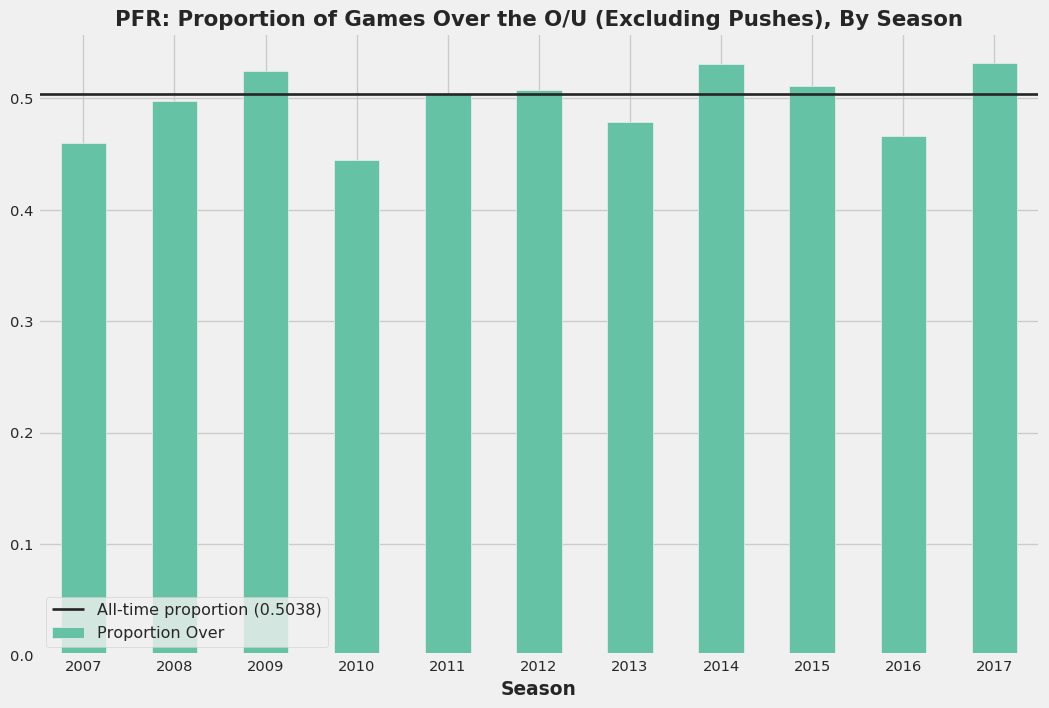

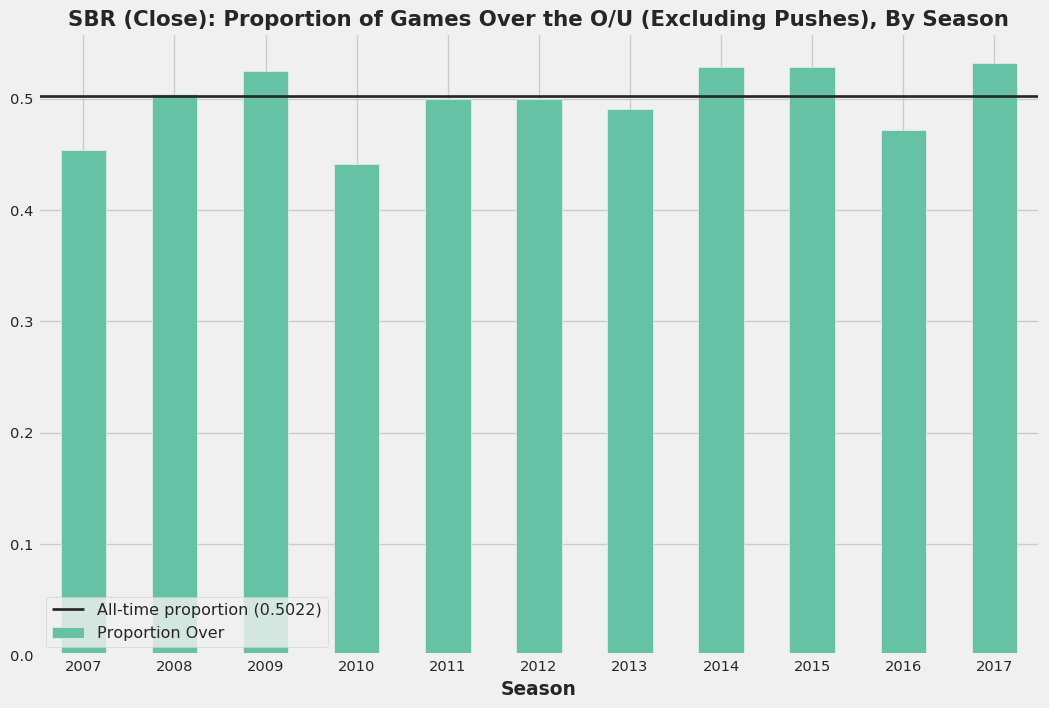

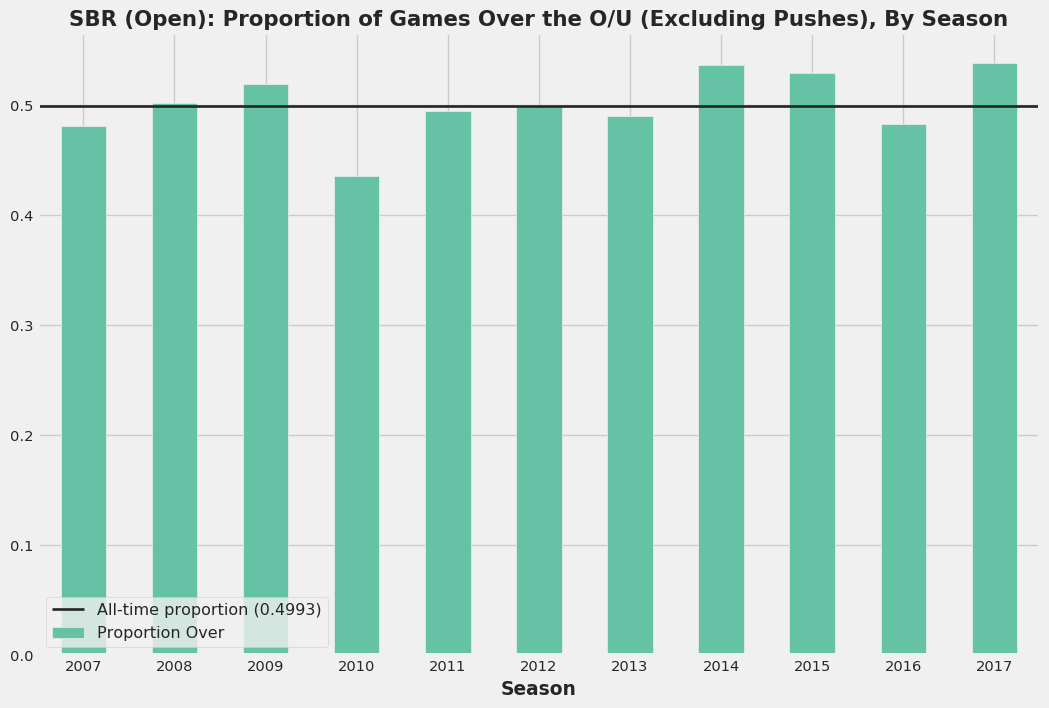

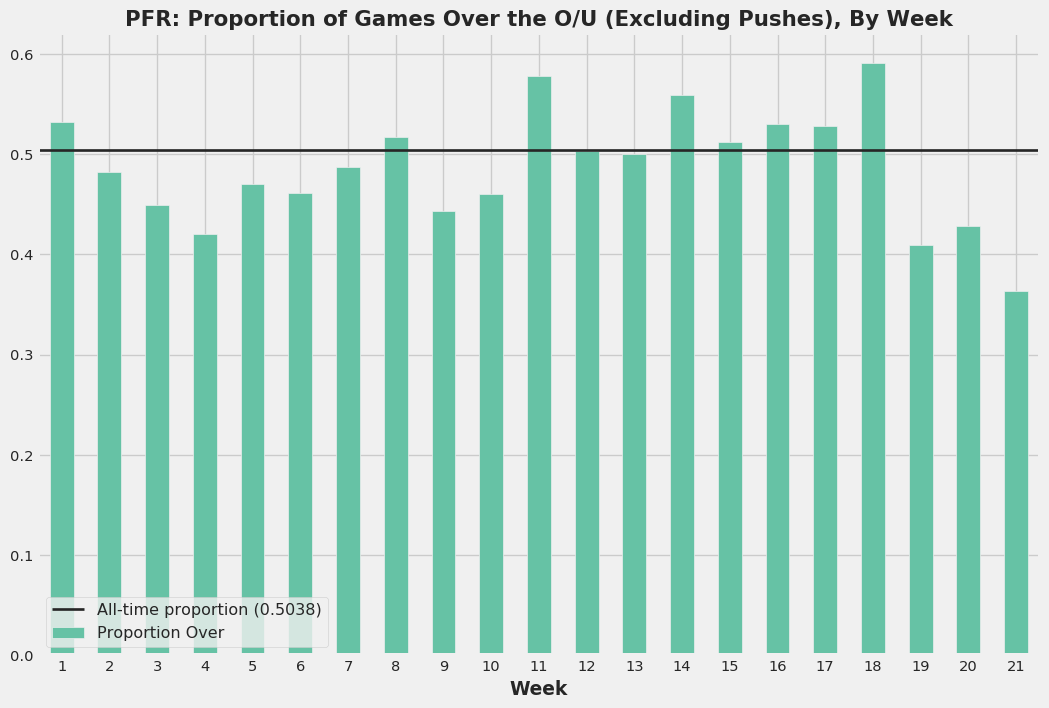

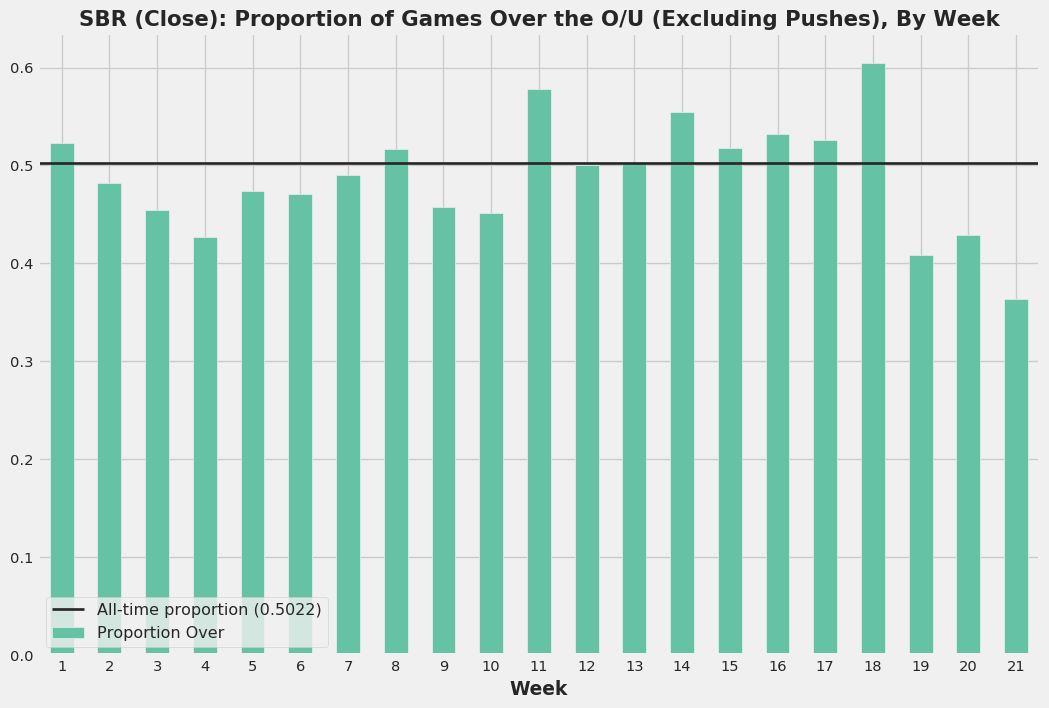

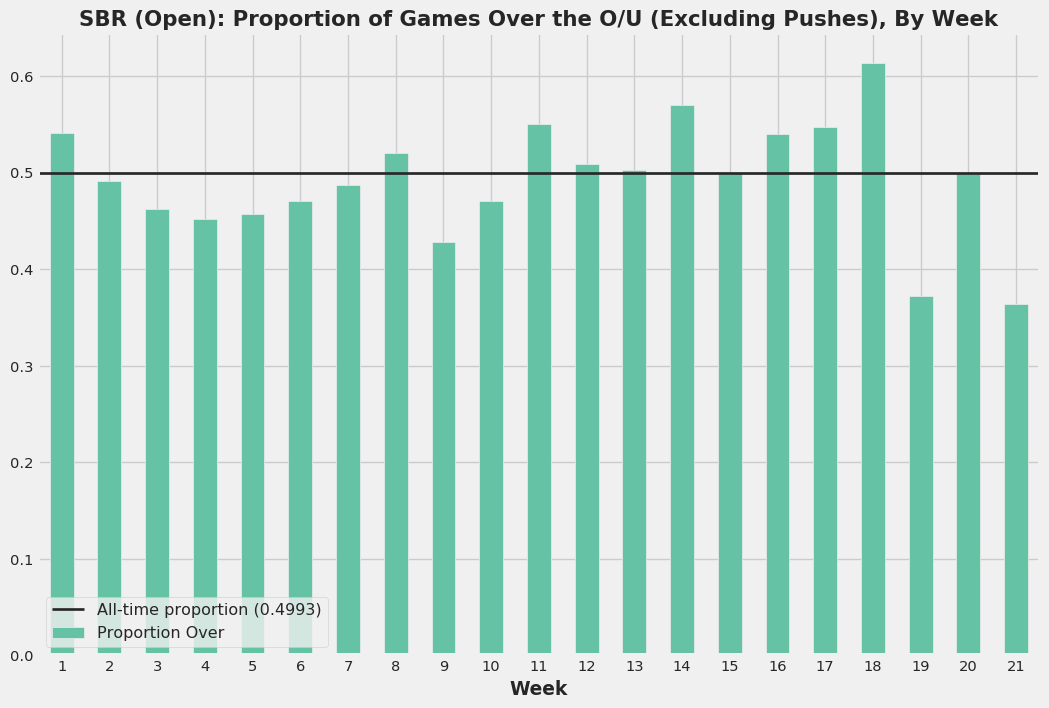

In [38]:
for time_dim, time_str in [('season','Season'),('week_id','Week')]:
    for ou_field, ou_name in [('pfr_ou','PFR'),('sbr_ou','SBR (Close)'),
                              ('sbr_ou_open','SBR (Open)')]:
        curr = ou_df.groupby(time_dim)\
                    .pivot('is_{}_over'.format(ou_field))\
                    .count()\
                    .toPandas()\
                    .rename(columns={time_dim:time_str})
        tot_all = curr[['-1','1']].sum(axis=0)
        tot_prop = tot_all['-1'] / tot_all.astype(float).sum()

        curr['Proportion Over'] = curr['1'] / (curr['-1'] + curr['1'])
        curr = curr.set_index(time_str).sort_index()
        _ = curr[['Proportion Over']].plot(
            kind='bar', rot=0, legend=None,
            title='{}: Proportion of Games Over the O/U (Excluding Pushes), By {}'
                     .format(ou_name, time_str)
        )
        _ = plt.axhline(
            y=tot_prop, color='#262626', linewidth=2,
            label='All-time proportion ({:.4f})'.format(tot_prop)
        )
        _ = plt.legend(loc=3)

#### Proportion *Over* for Different O/U Values

In [39]:
ou_bin_map = generate_pctiles(ou_df, 'sbr_ou', 10)
ou_bin_prop = apply_pctiles(
    ou_df, ou_bin_map, 'sbr_ou', 'is_sbr_ou_over', 
    'Over/Under Decile', 'Proportion Over'
)

In [40]:
ou_bin_prop

,-1,0,1,Proportion Over
Over/Under Decile,,,,
"[31.0, 38.0]",155,2,119,0.434307
"(38.0, 40.0]",140,10,124,0.469697
"(40.0, 41.0]",125,4,116,0.481328
"(41.0, 42.5]",149,1,169,0.531447
"(42.5, 43.5]",149,8,136,0.477193
"(43.5, 44.5]",128,5,144,0.529412
"(44.5, 46.0]",156,3,164,0.512500
"(46.0, 47.0]",118,5,134,0.531746
"(47.0, 49.5]",187,3,185,0.497312


Low Over/Unders: The bottom ~30% (41 and below) are over only 46%

Over/Unders at 41 and below go over 46.1%


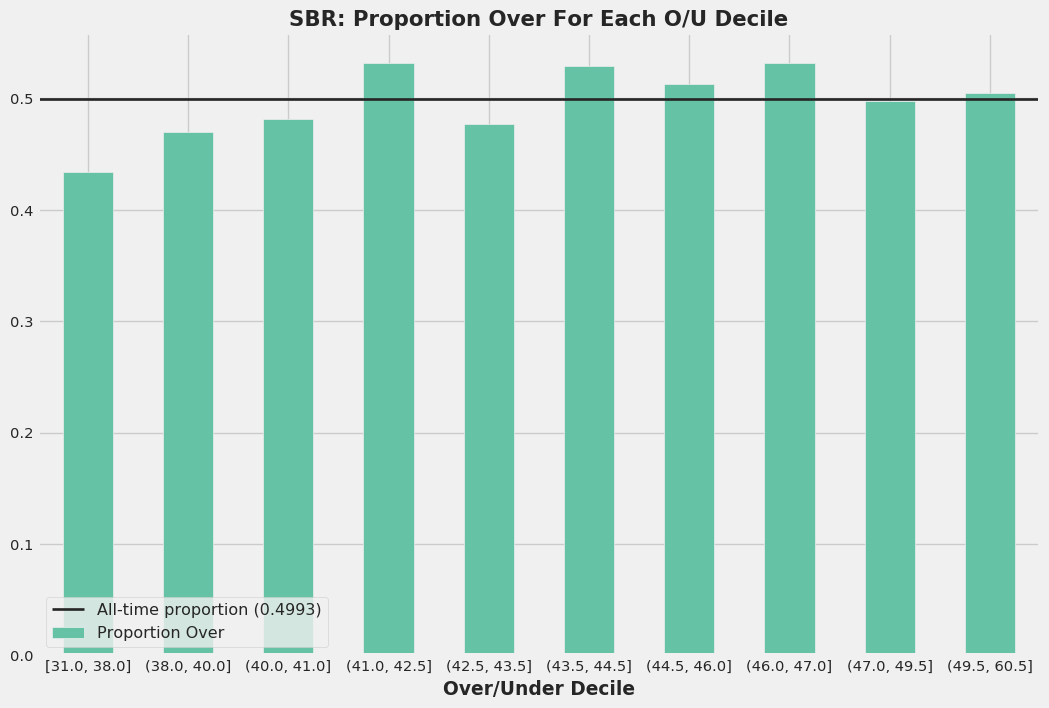

In [41]:
tmp = ou_bin_prop.iloc[:3, :].sum()
print 'Over/Unders at 41 and below go over {:.1f}%'\
            .format(tmp['1'].sum() / float(tmp[['-1','1']].sum())*100)

_ = ou_bin_prop[['Proportion Over']].plot(
    kind='bar', rot=0, legend=None,
    title='SBR: Proportion Over For Each O/U Decile'
)
_ = plt.axhline(
    y=tot_prop, color='#262626', linewidth=2,
    label='All-time proportion ({:.4f})'.format(tot_prop)
)
_ = plt.legend(loc=3)    

### Form game line labels
* #### Goal: 2 rows for each game
* key is (game_id, team_id)
* compute labels as needed
* doesn't work for Over/Under

In [42]:
## only select needed columns for labels
df_base = df.select(
        'game_id','season','week_id','is_neutral','h_team_id','v_team_id',
        'h_name','v_name','h_final','v_final','h_ml','v_ml','close_fav',
        'close_spread','pfr_fav','pfr_spread','open_fav','open_spread'
    )

#### Add moneyline breakeven point

In [43]:
df_base.limit(5).toPandas().T

,0,1,2,3,4
game_id,201511150ram,201511090sdg,201510180det,201512270tam,201510110kan
season,2015,2015,2015,2015,2015
week_id,10,9,6,16,5
is_neutral,0,0,0,0,0
h_team_id,ram,sdg,det,tam,kan
v_team_id,chi,chi,chi,chi,chi
h_name,Rams,Chargers,Lions,Buccaneers,Chiefs
v_name,Bears,Bears,Bears,Bears,Bears
h_final,13,19,37,21,17
v_final,37,22,34,26,18


In [44]:
for h_v in ['h','v']:
    ml_col = '{}_ml'.format(h_v)
    prob_col = '{}_ml_be'.format(h_v)
    df_base = df_base.withColumn(
            prob_col,
            F.when(col(ml_col) <= 0, -col(ml_col) / (F.lit(100.) - col(ml_col)))
             .otherwise(F.lit(100.) / (F.lit(100.) + col(ml_col)))
        ).withColumn(
            prob_col, F.round(col(prob_col)*100, 0) / F.lit(100.)
        )

#### Create a row for each (game_id, team) pair and standardize columns
* remove/replace home/visitor indicators
* add columns for filtering
  * is_home {0, 1}
  * is_fav (for SBR and PFR) {-1, 0, 1} --> {no, pick'em, yes}
* add labels
  * game point margin relative to team
  * did win {-1, 0, 1} --> {lose, tie, win}
  * did cover {-1, 0, 1} --> {no, push, yes}
* rename the "close" line convention to "sbr" since we'll only use closing line

In [45]:
## find the h_* and v_* fields
hv_cols = filter(lambda x: x.split('_')[0] in ['h','v'], df_base.columns)
hv_cols = list(set(map(lambda x: x[2:], hv_cols)))

split_dfs = {}
for h_v in ['h','v']:
    ## team, team name, and final score for opposing team
    other = {'h':'v', 'v':'h'}[h_v]
    curr = df_base.withColumnRenamed(
            '{}_team_id'.format(other), 'opp_team_id'
        ).withColumnRenamed(
            '{}_name'.format(other), 'opp_name'
        ).withColumnRenamed(
            '{}_final'.format(other), 'opp_final'
        )
    
    ## for the other columns, keep only the current 'h' or 'v'
    ## and rename it
    for c in hv_cols:
        curr = curr.withColumnRenamed('{}_{}'.format(h_v, c), c)\
                   .drop('{}_{}'.format(other, c))
    
    ## binary home and favorite columns
    ## rename "close" --> "sbr"
    curr = curr.withColumn(
            'is_home', 
            F.when(col('is_neutral') == 1, 0.5)
             .otherwise(F.lit(1) if h_v == 'h' else F.lit(0))
        ).withColumn(
            'final_margin', col('final') - col('opp_final')
        ).withColumn(
            'did_win', 
            F.when(col('final_margin') > 0, 1)
             .when(col('final_margin') < 0, -1)
             .otherwise(0)
        ).drop('is_neutral')
    
    for col_rename in ['close_spread','close_fav','open_spread','open_fav']:
        curr = curr.withColumnRenamed(
            col_rename, col_rename.replace('close','sbr')
                                  .replace('open','sbr_open')
        )
    
    ## binary is_fav and did_cover fields for PFR and SBR (close)
    for line_site in ['pfr','sbr','sbr_open']:
        ## new column
        is_fav_col = 'is_fav_{}'.format(line_site)
        ## existing columns
        fav_col = '{}_fav'.format(line_site)
        spread_col = '{}_spread'.format(line_site)
        
        curr = curr.withColumn(
            is_fav_col, 
            F.when(col(fav_col) == h_v.upper(), 1)
             .when(col(fav_col) == 'PK', 0)
             .when(col(fav_col) == other.upper(), -1)
        ).withColumn(
            'did_cover_{}'.format(line_site), 
            F.when(
                col('final_margin') 
                 > col(is_fav_col) * col(spread_col), 
               1
            ).when(
                col('final_margin') 
                 < col(is_fav_col) * col(spread_col), 
               -1
            ).otherwise(0)
        ).drop(fav_col)
        
    split_dfs[h_v] = curr

#### Hive table: __team_game_line_labels__

In [46]:
cols = split_dfs['h'].columns
split_dfs['h'].union(
    split_dfs['v'].select(*cols)
).write.mode('overwrite').saveAsTable('labels.team_game_line_labels')

### Explore Game Labels

#### How often do different Moneylines cover?

In [47]:
df = spark.table('labels.team_game_line_labels').cache()

In [48]:
df.withColumn('ml_fav', F.when(col('ml_be') > 0.5, 1).otherwise(0)).groupby('ml_fav').pivot('did_win').count().toPandas()

,ml_fav,-1,0,1
0,1,1008,6,2011
1,0,1923,6,920


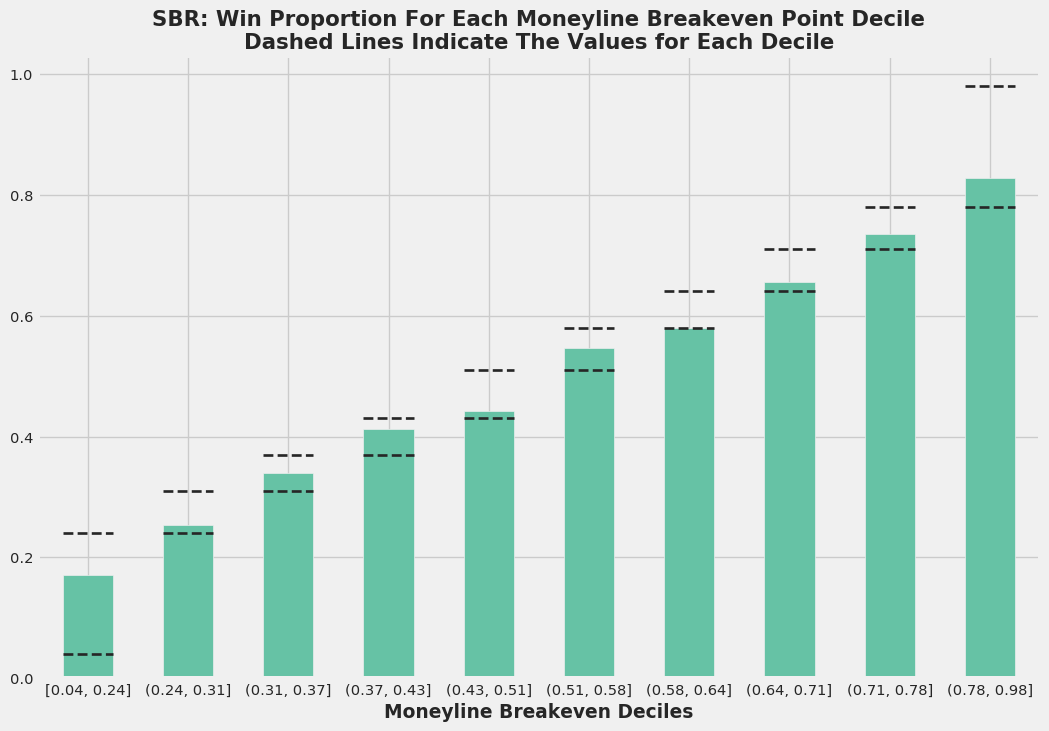

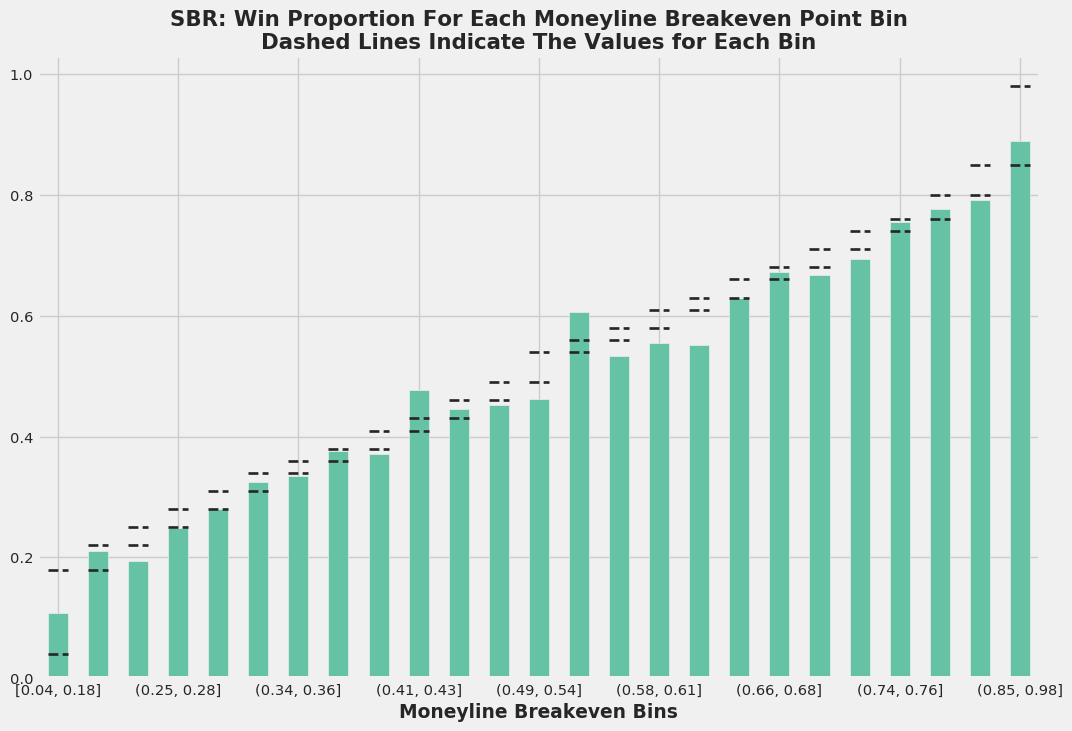

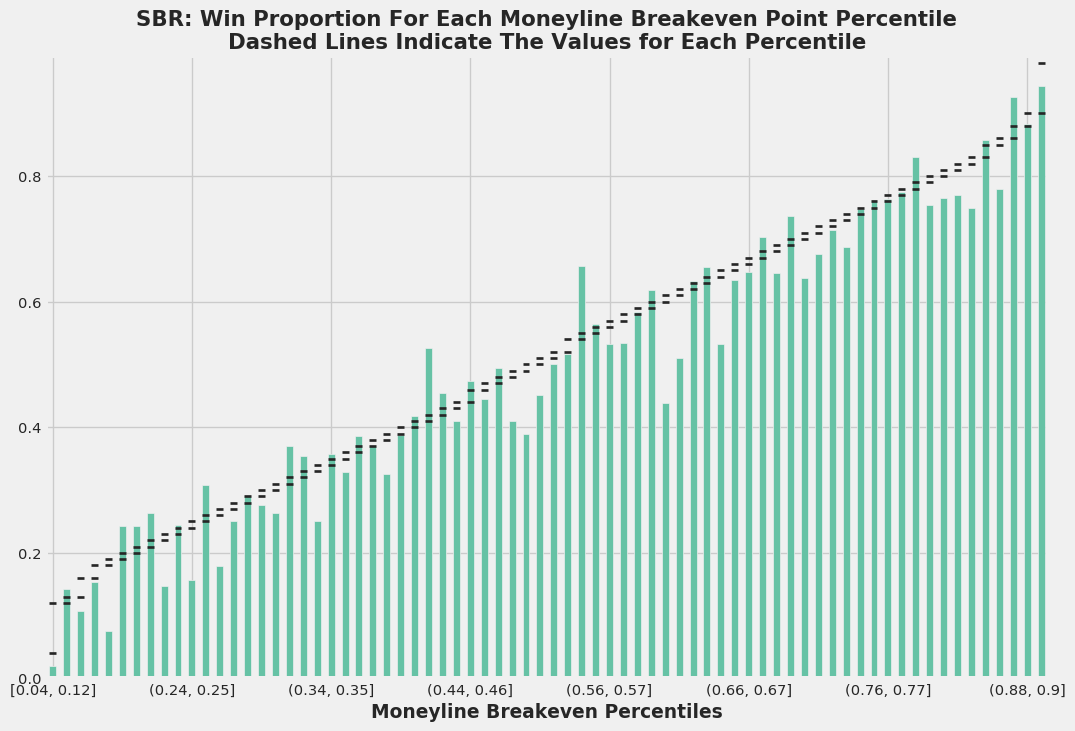

In [49]:
for pctiles, ntile_name, skiptick in [(10, 'Deciles', 1), 
                                      (25, 'Bins', 3), 
                                      (100, 'Percentiles', 10)]:

    ml_bin_map = generate_pctiles(df, 'ml_be', pctiles)
    ml_bin_prop = apply_pctiles(
        df, ml_bin_map, 'ml_be', 'did_win', 
        'Moneyline Breakeven {}'.format(ntile_name), 'Win Proportion'
    )

    bin_vals = map(
        lambda x: map(float, x[1:-1].split(', ')), 
        ml_bin_prop.index.tolist()
    )    

    _ = ml_bin_prop[['Win Proportion']].plot(
        kind='bar', rot=0, legend=None,
        title='SBR: Win Proportion For Each Moneyline Breakeven Point {0}'
               '\nDashed Lines Indicate The Values for Each {0}'
                 .format(ntile_name[:-1])
    )

    nbins = float(len(bin_vals))
    gap = 0.25/nbins
    for i, vals in enumerate(bin_vals):
        for val in vals:
            _ = plt.axhline(
                y=val, xmin=i/nbins+gap, xmax=(i+1)/nbins-gap,
                color='#262626', linewidth=2, linestyle='--'
            )
    a, b = plt.xticks()
    _ = plt.xticks(a[::skiptick], b[::skiptick])

#### How often do different Spreads Cover

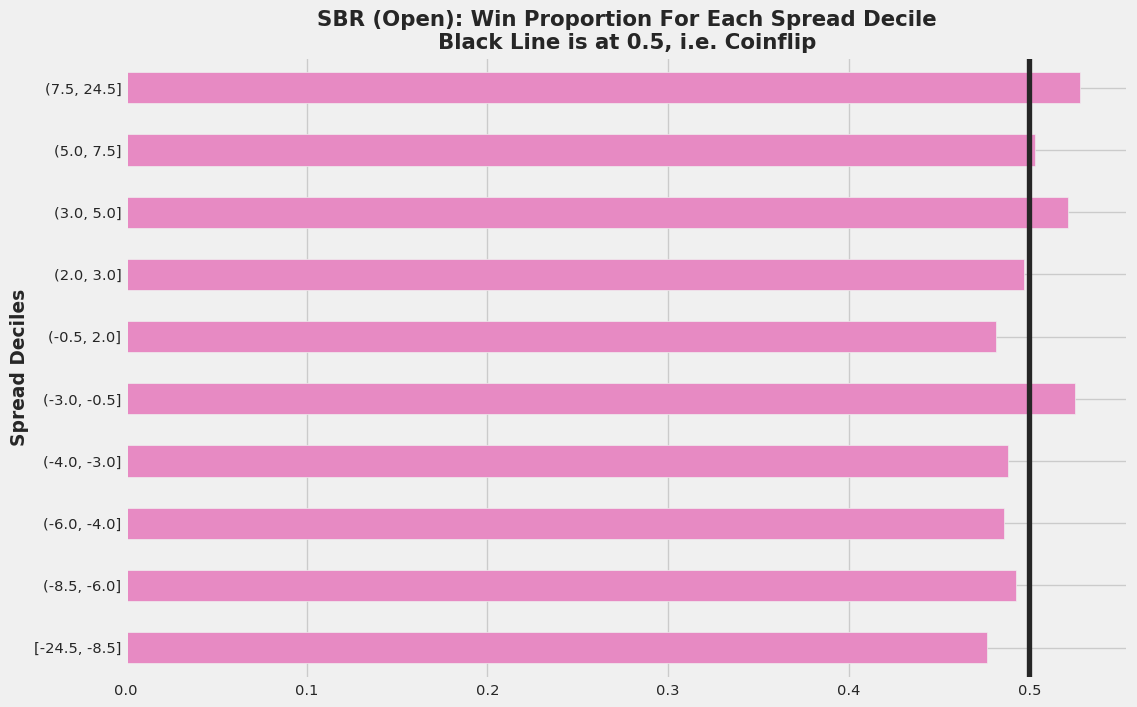

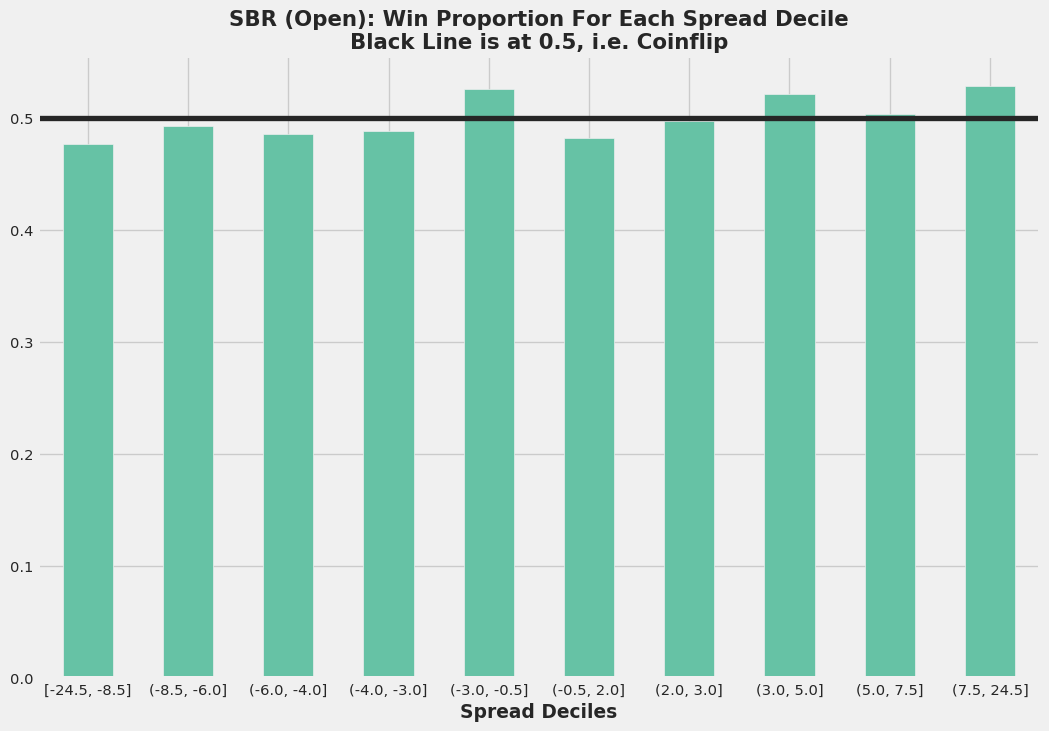

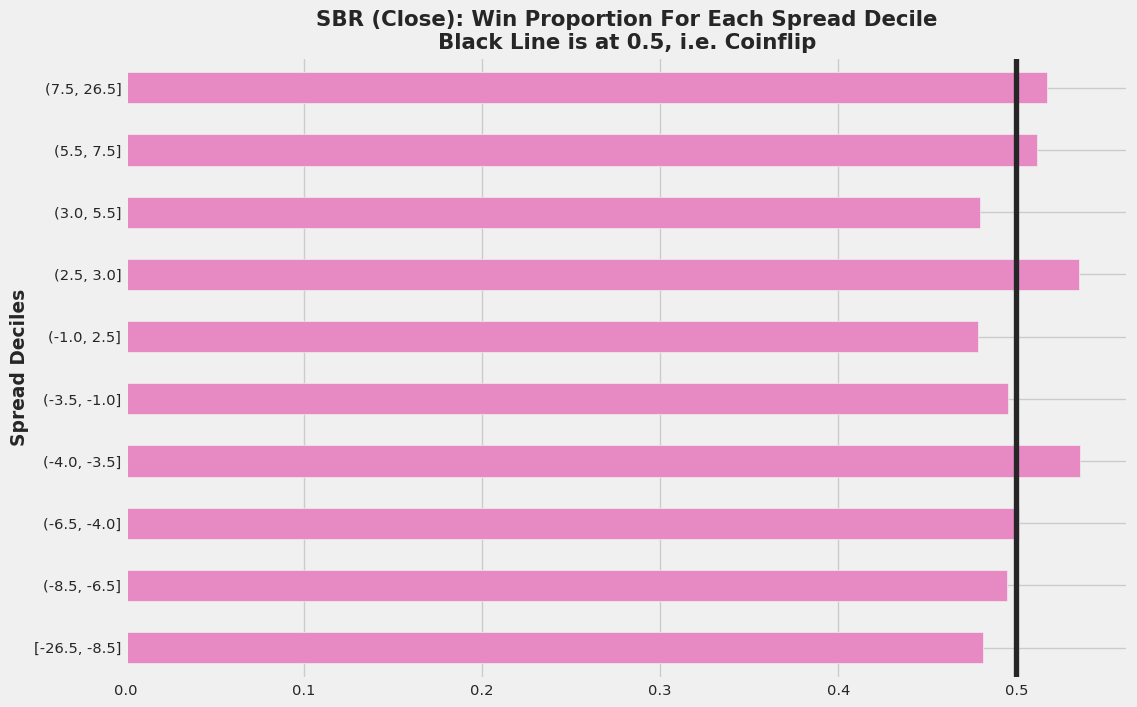

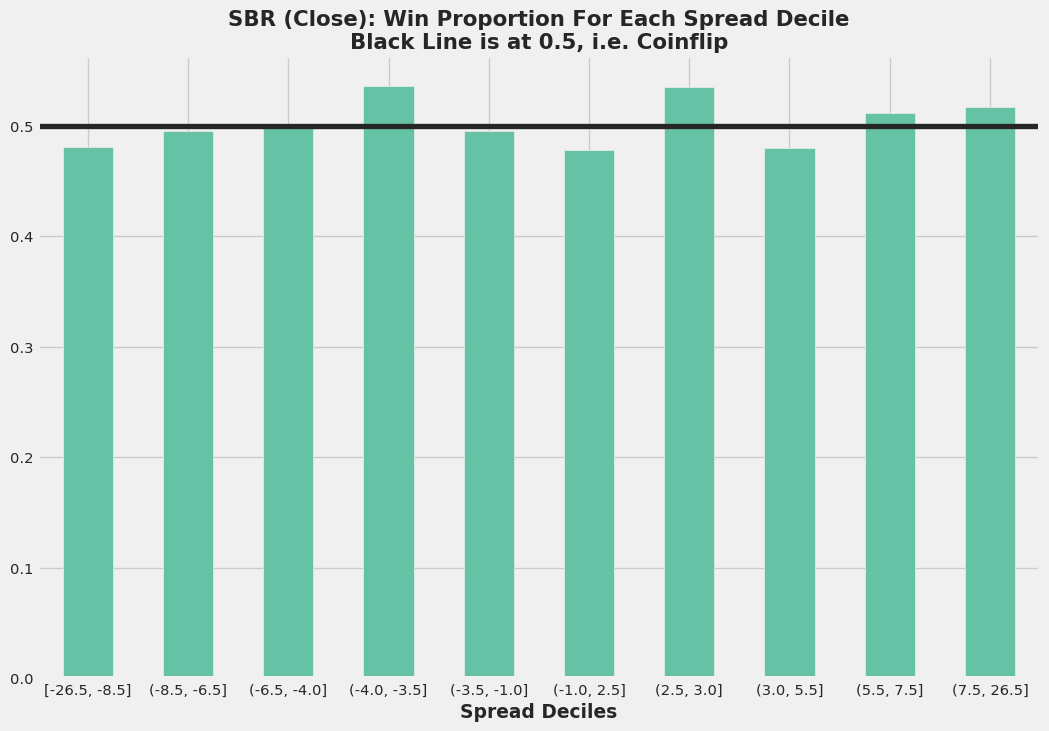

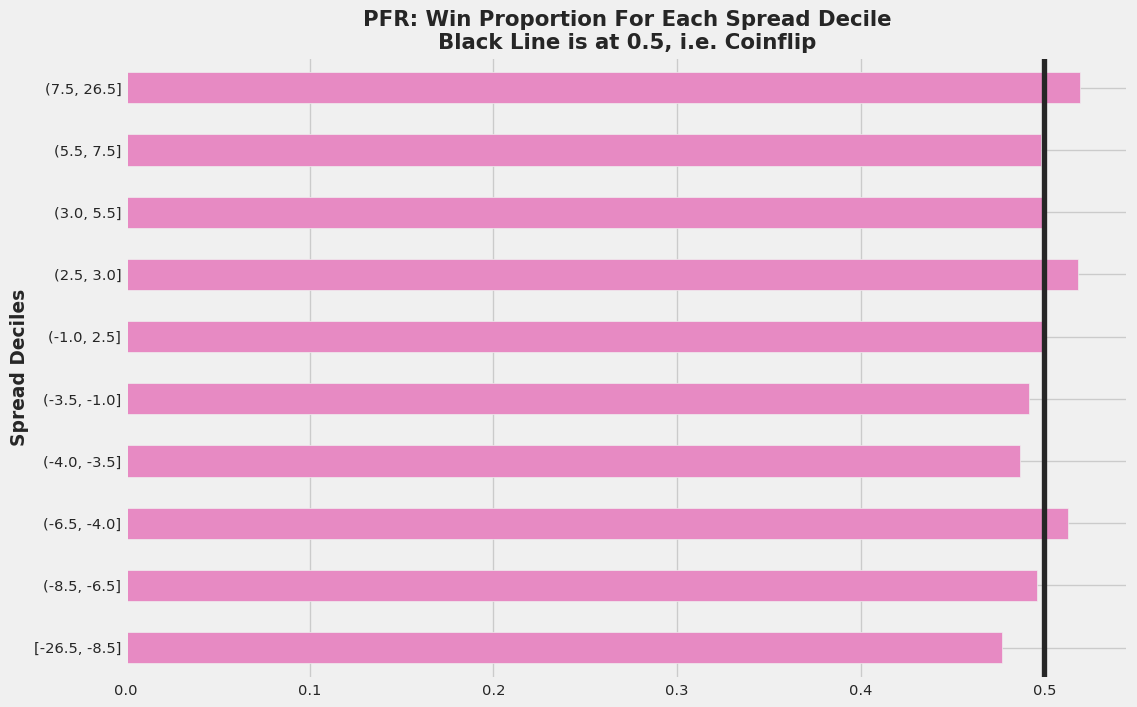

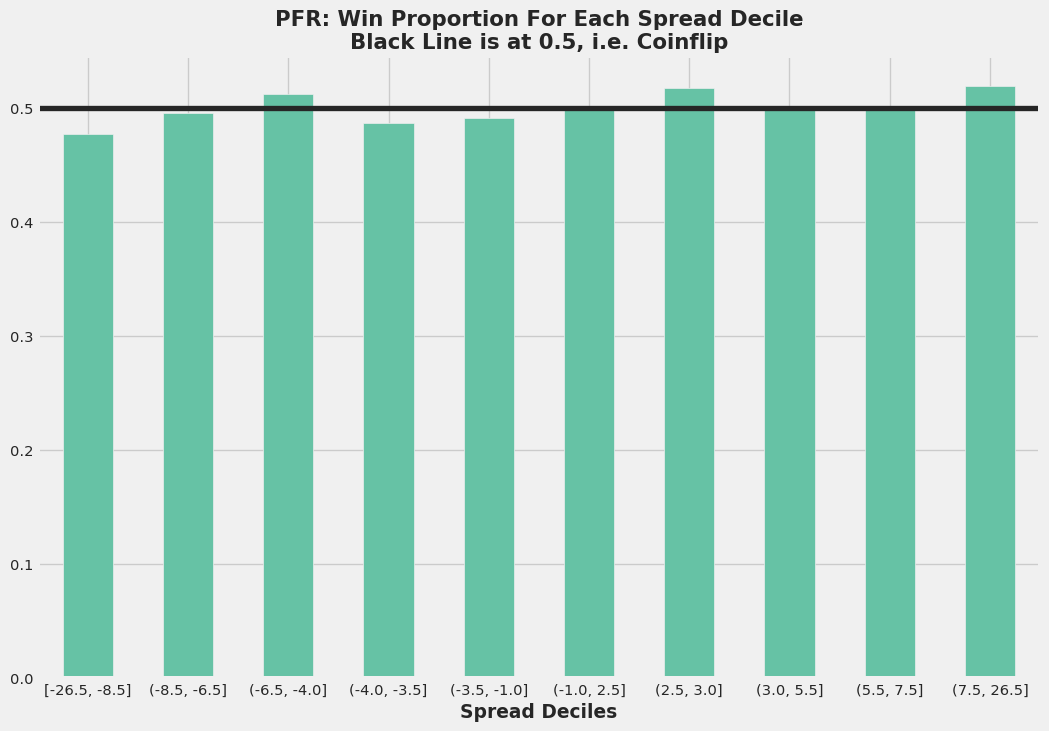

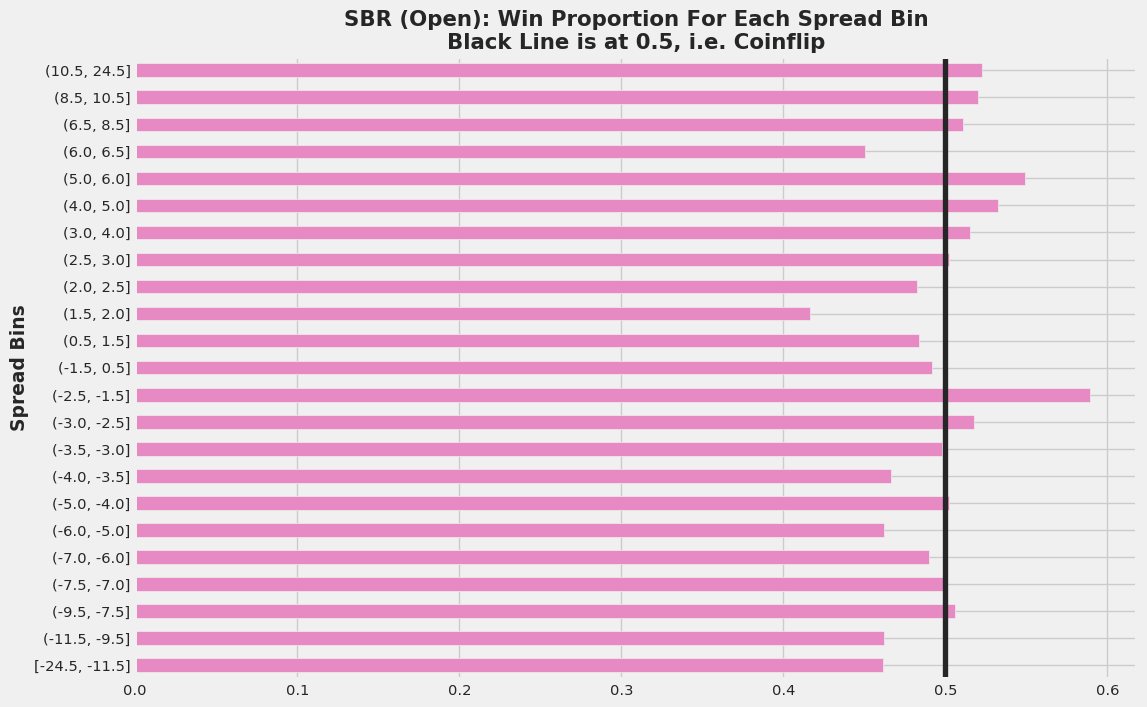

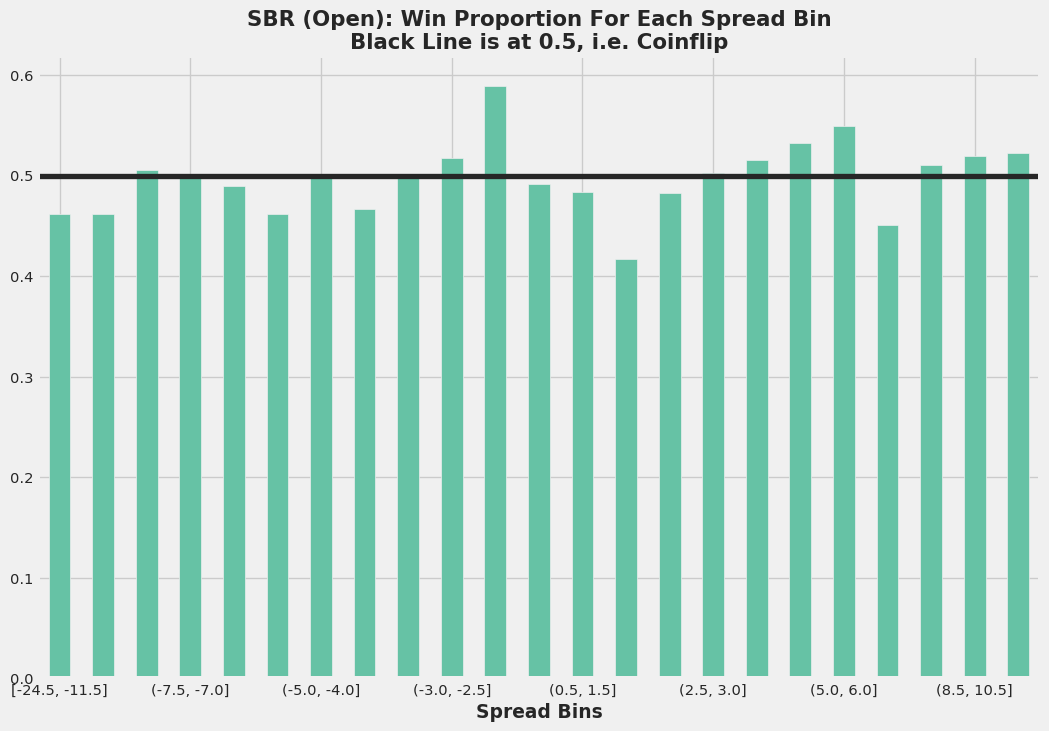

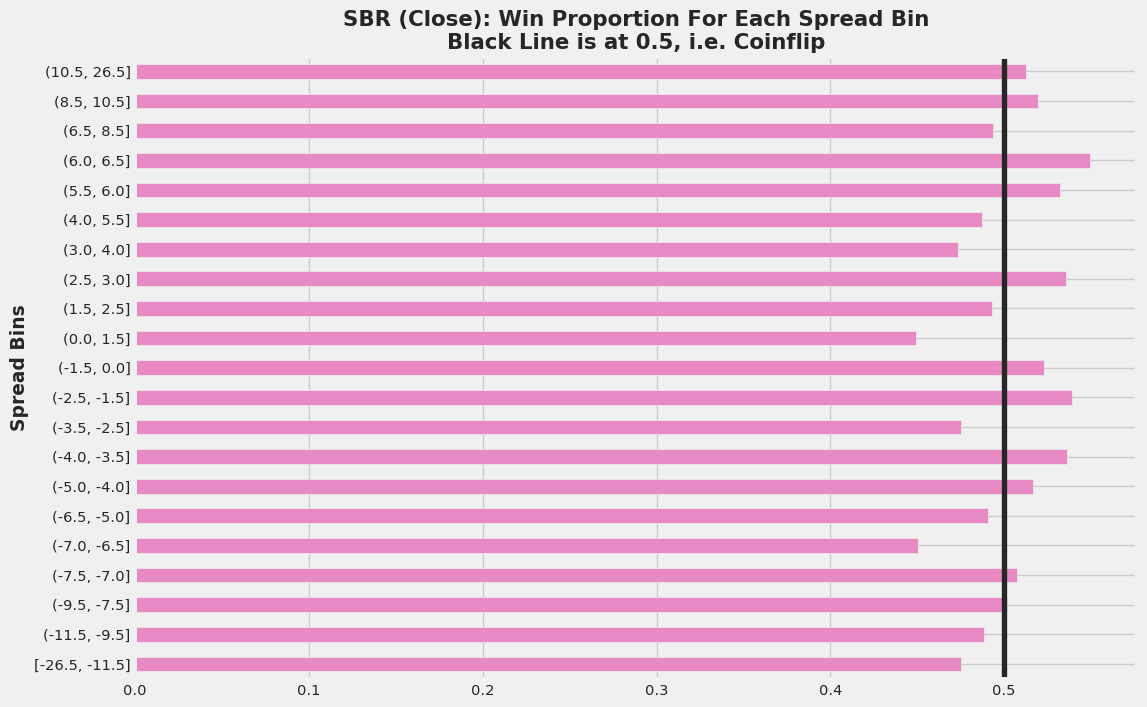

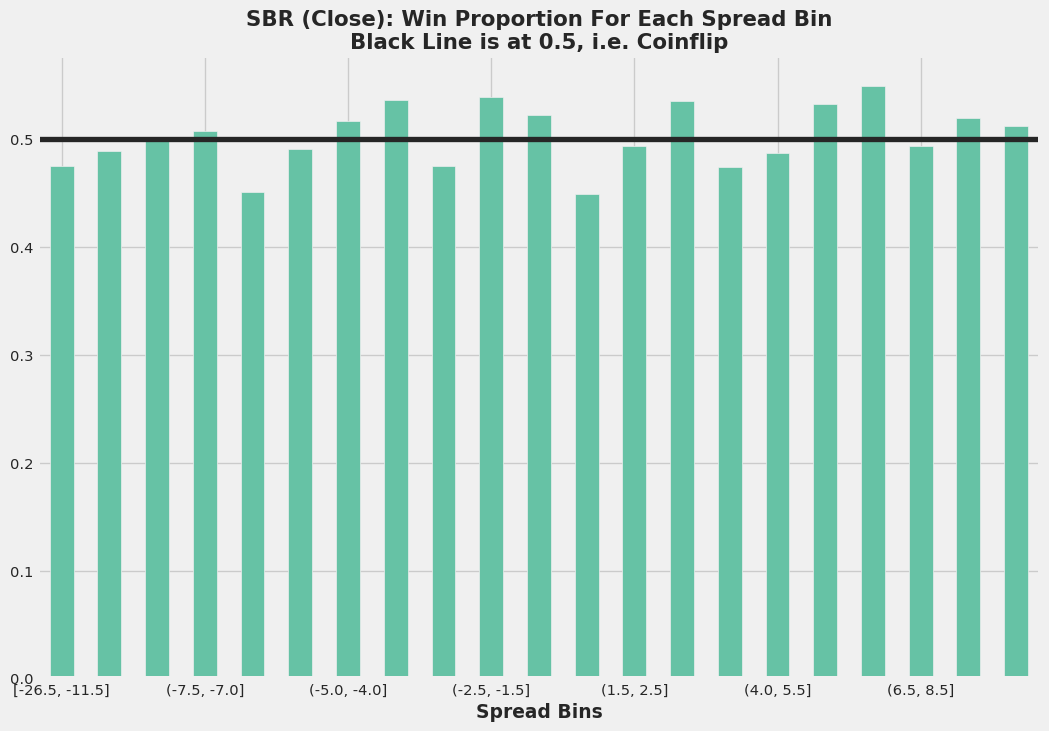

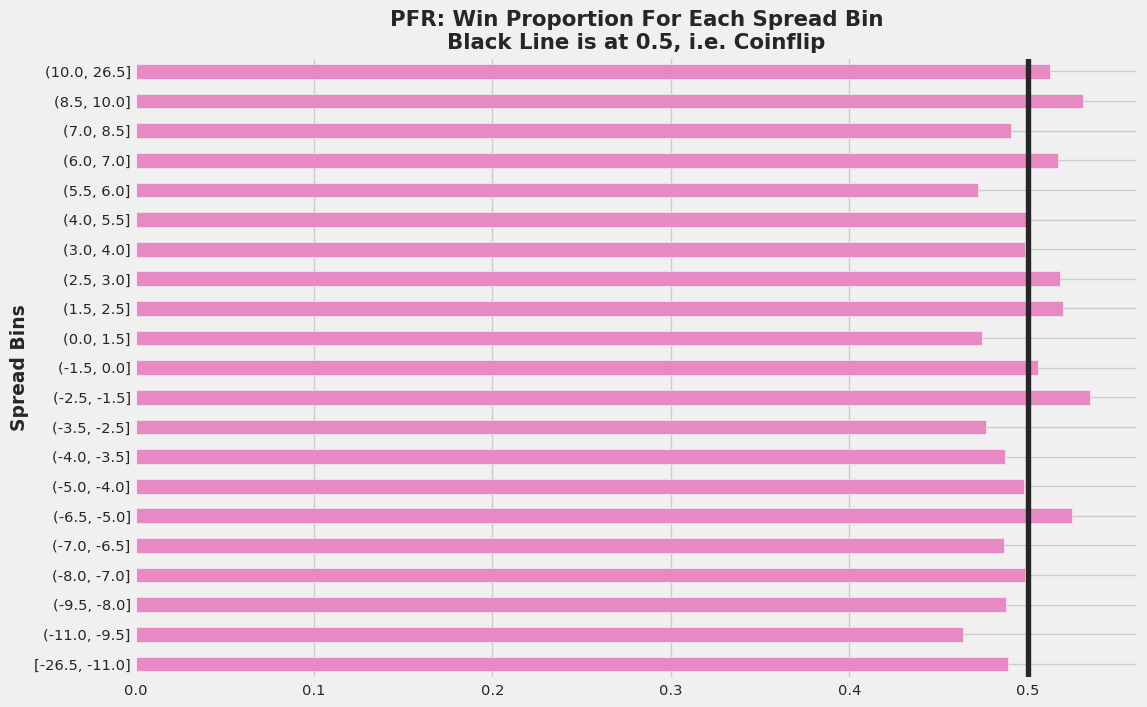

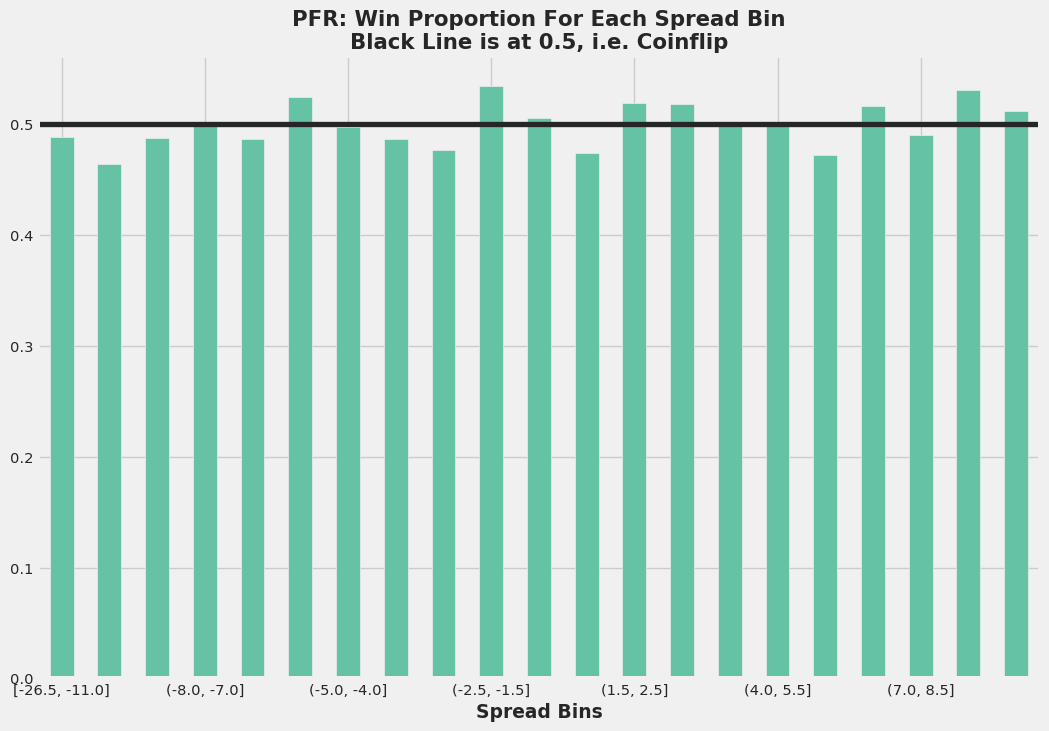

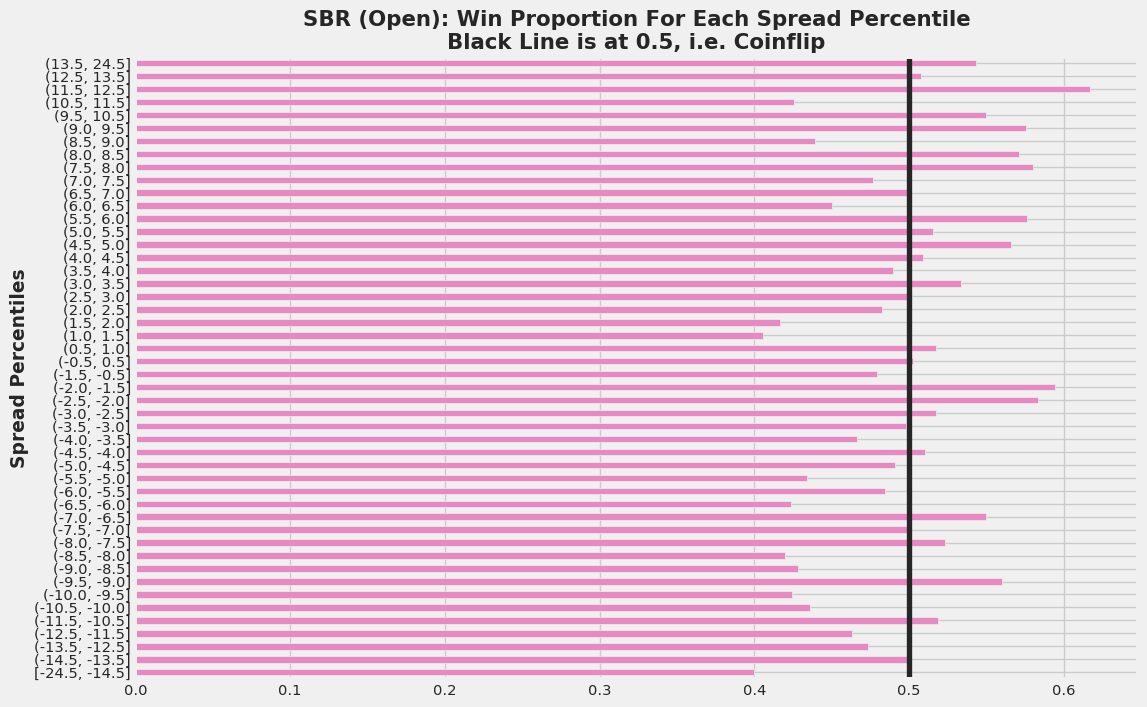

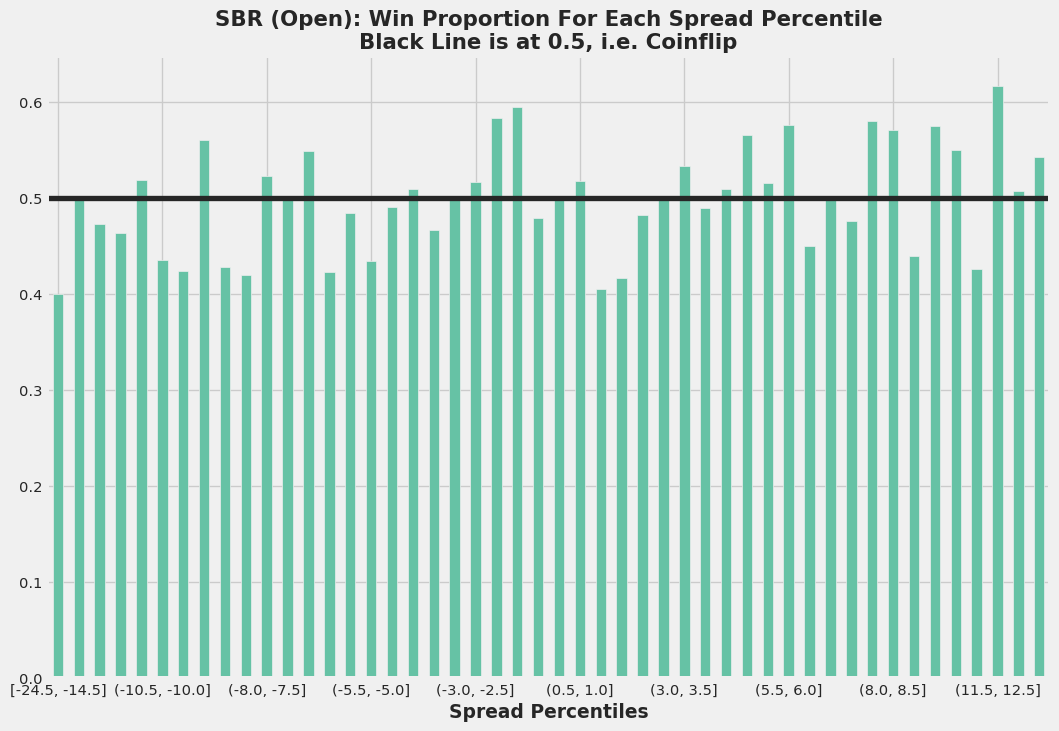

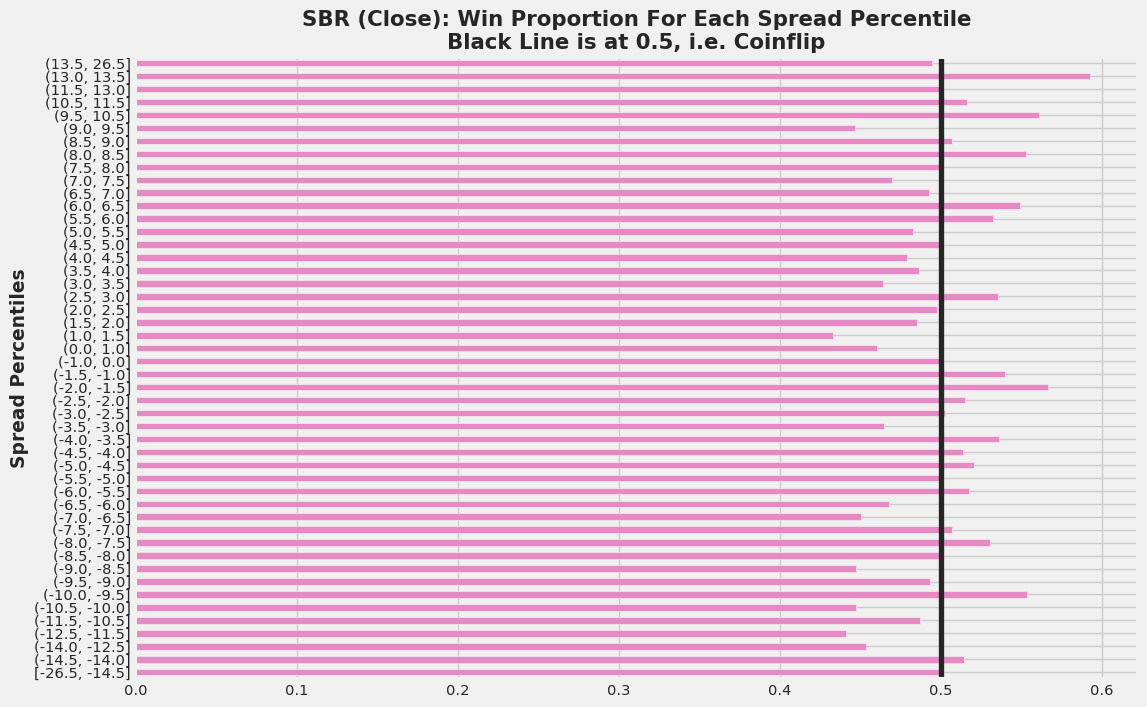

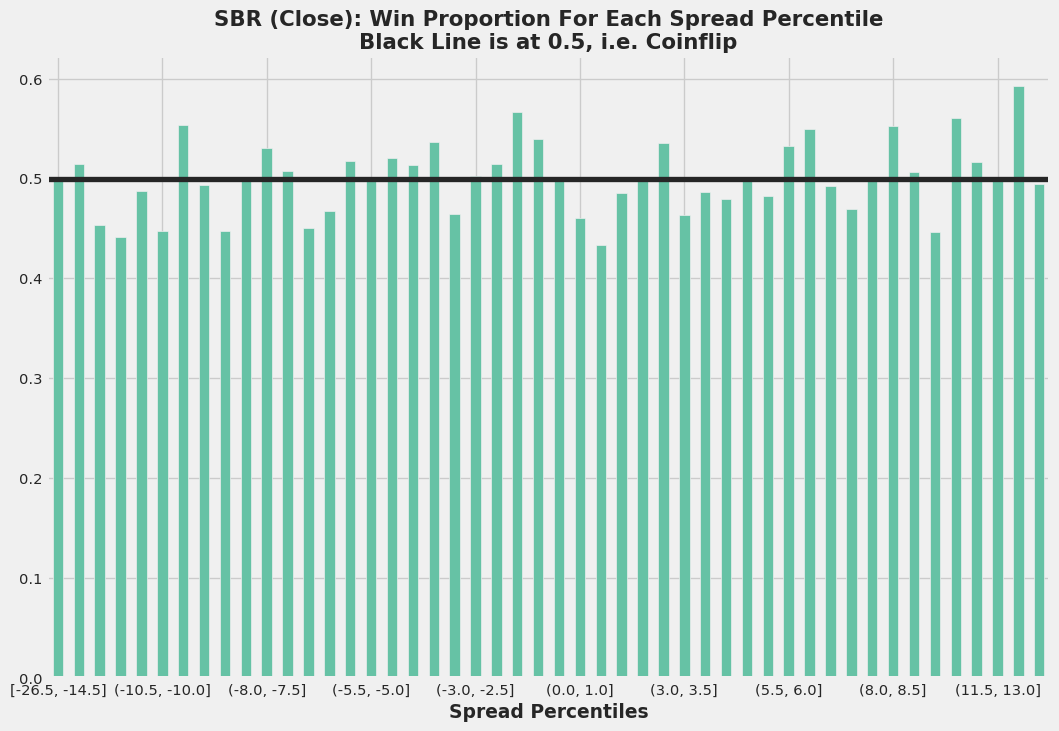

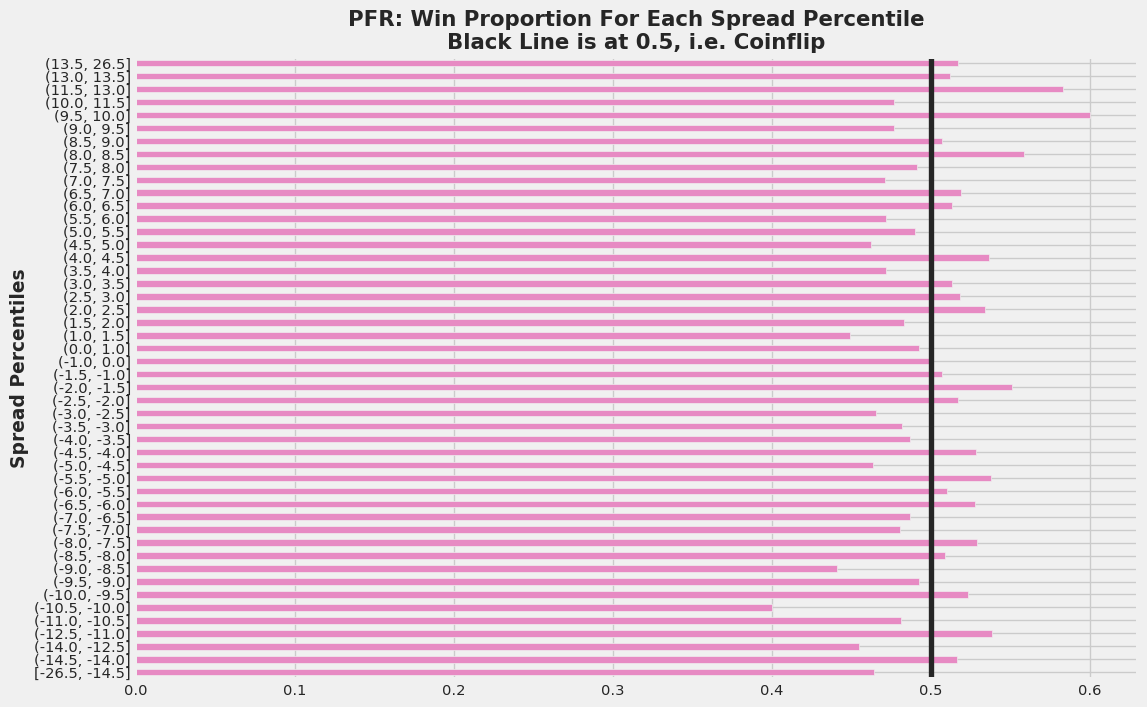

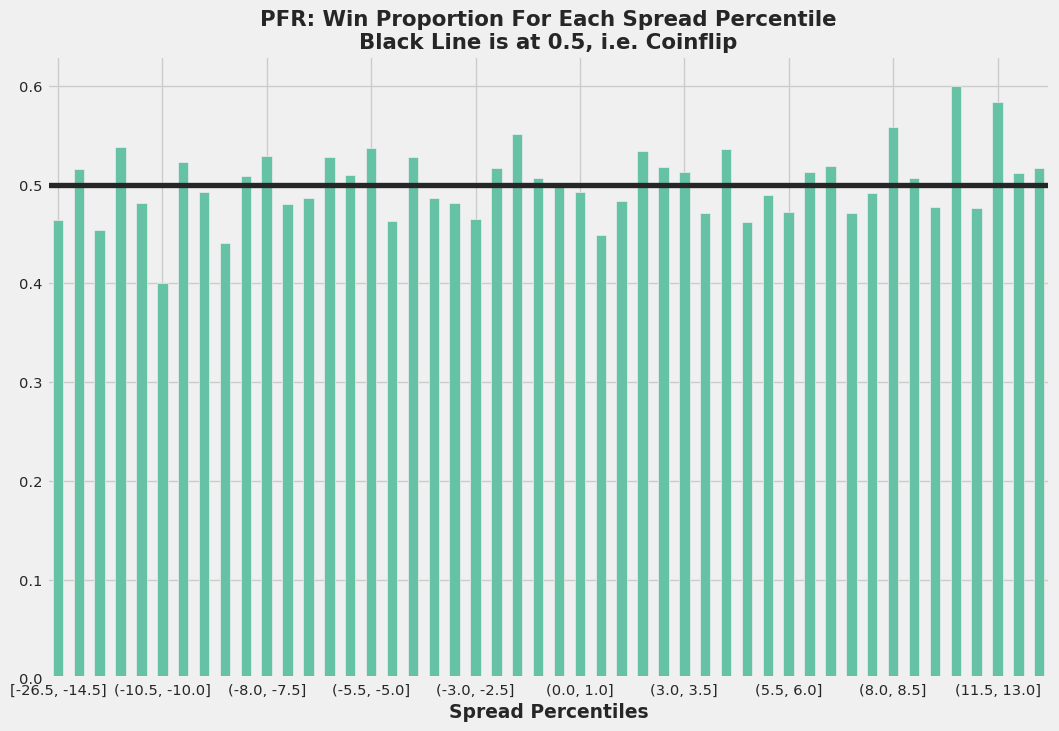

In [50]:
df_spread = df.select(
    'sbr_spread','pfr_spread','sbr_open_spread',
    'did_cover_sbr','did_cover_pfr','did_cover_sbr_open',
    'is_fav_sbr','is_fav_pfr','is_fav_sbr_open'
)

for pctiles, ntile_name, skiptick in [(10, 'Deciles', 1), 
                                      (25, 'Bins', 3), 
                                      (100, 'Percentiles', 5)
                                     ]:

    for site_line in ['sbr_open','sbr','pfr']:
        df_spread = df_spread.withColumn(
                '{}_spread_rel'.format(site_line),
                F.lit(-1) 
                * col('is_fav_{}'.format(site_line)) 
                * col('{}_spread'.format(site_line))
            )
        spread_bin_map = generate_pctiles(
            df_spread, '{}_spread_rel'.format(site_line), pctiles
        )
        spread_bin_prop = apply_pctiles(
            df_spread, spread_bin_map, '{}_spread_rel'.format(site_line), 
            'did_cover_{}'.format(site_line), 
            'Spread {}'.format(ntile_name), 
            'Cover Proportion'
        )
        
        site_str = {
            'sbr_open': 'SBR (Open)',
            'sbr': 'SBR (Close)',
            'pfr': 'PFR'
        }[site_line]
        
        ## horizontal bars
        _ = spread_bin_prop[['Cover Proportion']].plot(
            kind='barh', rot=0, legend=None, color=colors[3],
            title='{}: Win Proportion For Each Spread {}'
                  '\nBlack Line is at 0.5, i.e. Coinflip'
                     .format(site_str, ntile_name[:-1])
        )
        _ = plt.axvline(x=0.5)
        
        ## vertical bars
        _ = spread_bin_prop[['Cover Proportion']].plot(
            kind='bar', rot=0, legend=None,
            title='{}: Win Proportion For Each Spread {}'
                  '\nBlack Line is at 0.5, i.e. Coinflip'
                     .format(site_str, ntile_name[:-1])
        )
        _ = plt.axhline(y=0.5)
        a, b = plt.xticks()
        _ = plt.xticks(a[::skiptick], b[::skiptick])

#### How often did the favorite win?

In [51]:
df_fav = df.withColumn(
        'ML Favorite\'s', F.when(col('ml_be') > 0.5, 1)
                        .otherwise(0)
    )
col_renames = { 
    'is_fav_sbr': 'SBR (Close) Favorite\'s',
    'is_fav_sbr_open': 'SBR (Open) Favorite\'s',
    'is_fav_pfr': 'PFR Favorite\'s'
}

df_fav = reduce(
    lambda sdf,c: sdf.withColumnRenamed(c, col_renames[c]),
    col_renames.keys(),
    df_fav
)

cols_keep = ['game_id','season','week_id','is_home','did_win'] \
            + col_renames.values() + ['ML Favorite\'s']

In [52]:
df_fav.select(*cols_keep).limit(10).toPandas().T

,0,1,2,3,4,5,6,7,8,9
game_id,201511150ram,201511090sdg,201510180det,201512270tam,201510110kan,201512200min,201509270sea,201601030gnb,201511010chi,201512100crd
season,2015,2015,2015,2015,2015,2015,2015,2015,2015,2015
week_id,10,9,6,16,5,15,3,17,8,14
is_home,0,0,0,0,0,0,0,0,0,0
did_win,1,1,-1,1,1,-1,-1,1,1,-1
PFR Favorite's,-1,-1,-1,-1,-1,-1,-1,-1,1,-1
SBR (Close) Favorite's,-1,-1,-1,-1,-1,-1,-1,-1,1,-1
SBR (Open) Favorite's,-1,-1,-1,-1,-1,-1,-1,-1,1,-1
ML Favorite's,0,0,0,0,0,0,0,0,1,0


In [53]:
## how often does the home team win?
df_fav.groupby('is_home')\
    .pivot('did_win')\
    .count()\
    .withColumn('win_prop', col('1') / ( col('-1') + col('1') ))\
    .toPandas()\
    [['is_home','win_prop']]

,is_home,win_prop
0,0.0,0.426201
1,1.0,0.573799
2,0.5,0.500000


In [54]:
for i, fav_col in enumerate([
    'ML Favorite\'s', 'SBR (Close) Favorite\'s', 
    'SBR (Open) Favorite\'s', 'PFR Favorite\'s'
]):
    winrate_col = '{} Win Rate'.format(fav_col)
    tmp = df_fav.select(*cols_keep)\
                .groupby(fav_col)\
                .pivot('did_win')\
                .count()\
                .withColumn(winrate_col, 
                            col('1') / ( col('-1') + col('1') ))\
                .select(fav_col, winrate_col)\
                .toPandas()\
                .set_index(fav_col)
    if i == 0:
        winrates = tmp
    else:
        winrates = winrates.merge(
            tmp, left_index=True, right_index=True, how='outer'
        ).fillna(0)

In [55]:
winrates

,ML Favorite's Win Rate,SBR (Close) Favorite's Win Rate,SBR (Open) Favorite's Win Rate,PFR Favorite's Win Rate
-1,0.000000,0.325936,0.328506,0.330354
0,0.323602,0.500000,0.500000,0.500000
1,0.666115,0.674064,0.671494,0.669646


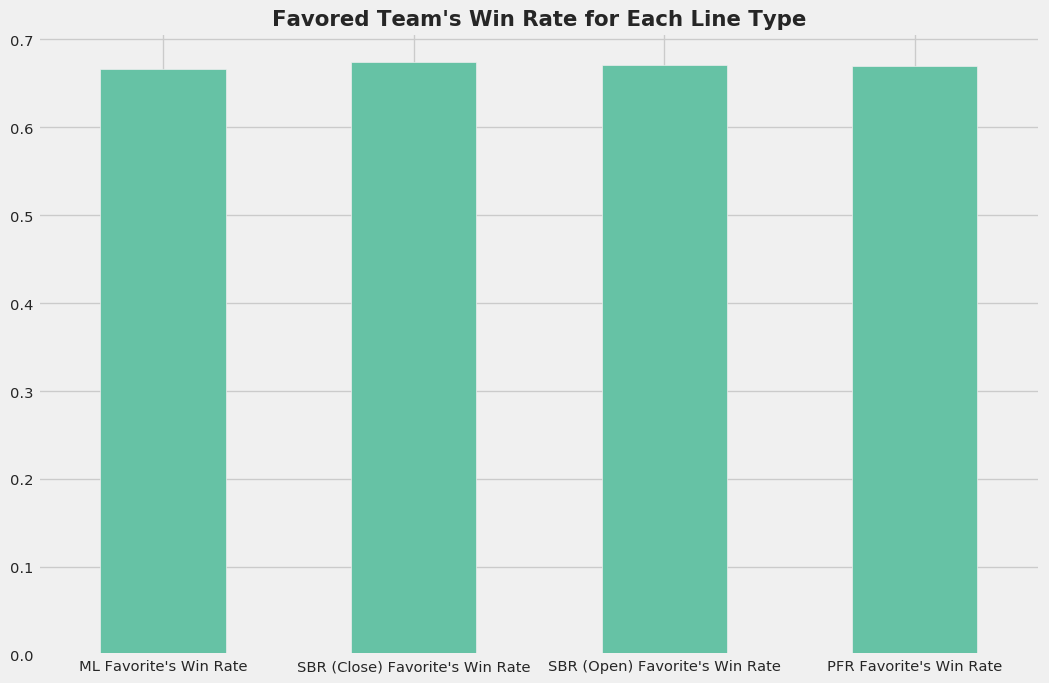

In [56]:
winrates.loc[1, :].plot(kind='bar', rot=0, color=colors[0],
              title='Favored Team\'s Win Rate for Each Line Type')

#### Dimensions
* 2-3 values
 * moneyline/spread
 * PFR/SBR Open/SBR Close ((for spread only)
 * home/visitor
 * fav/dog
* many values
 * season
 * week
 * focal team
 * opposing team

In [57]:
df.groupby('is_home').count().toPandas()

,is_home,count
0,0.0,2898
1,1.0,2898
2,0.5,78


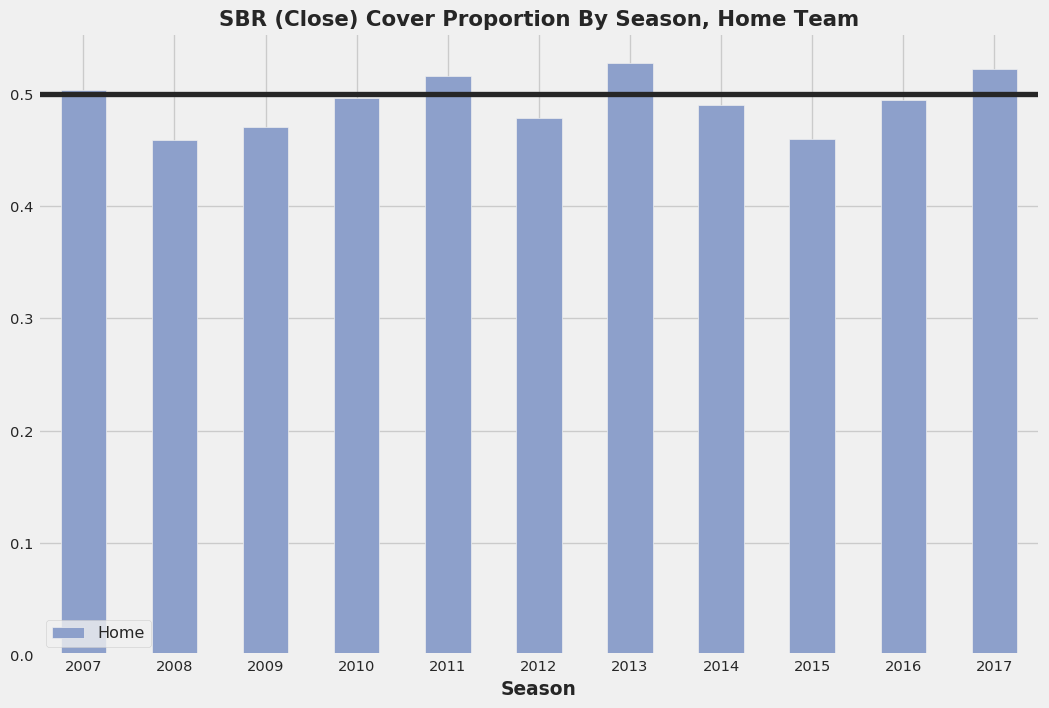

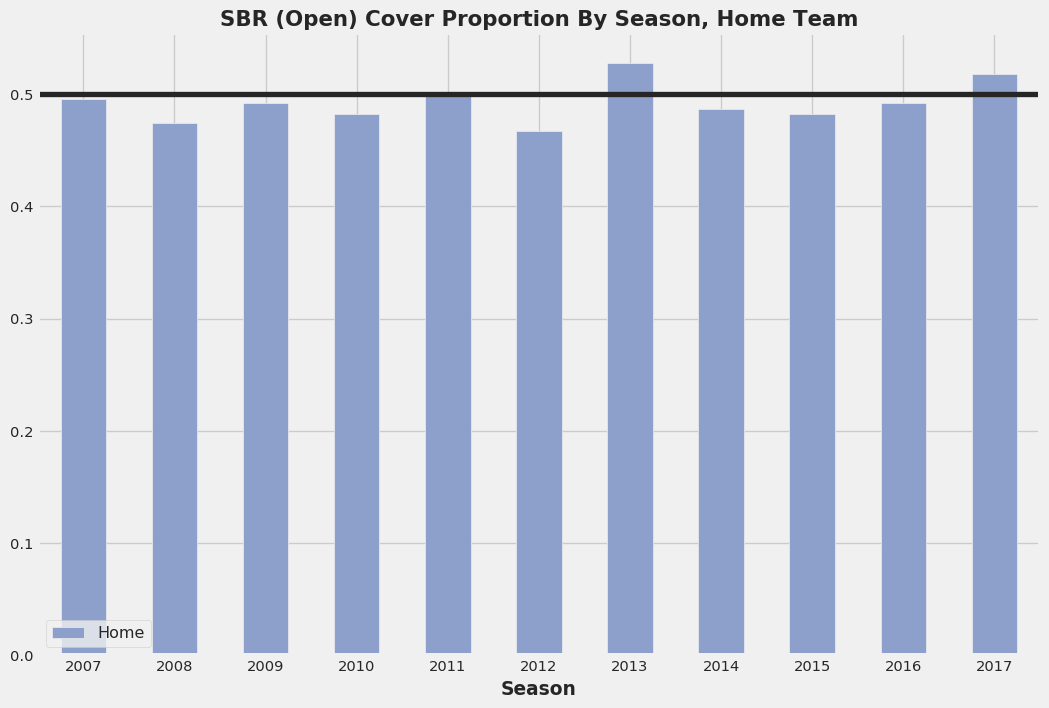

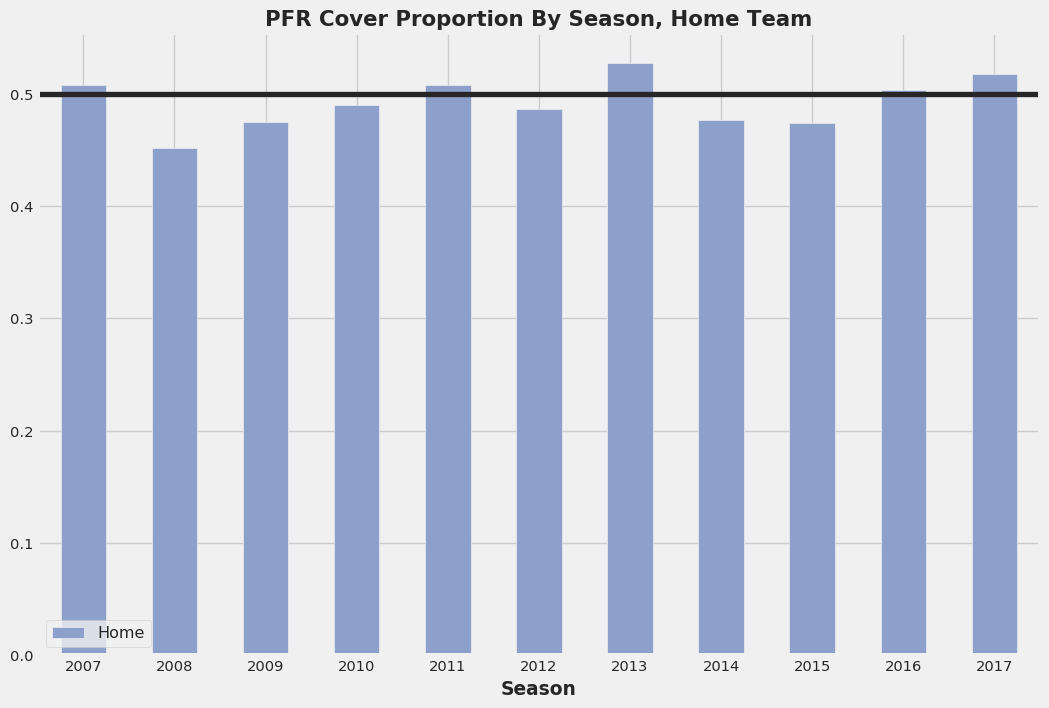

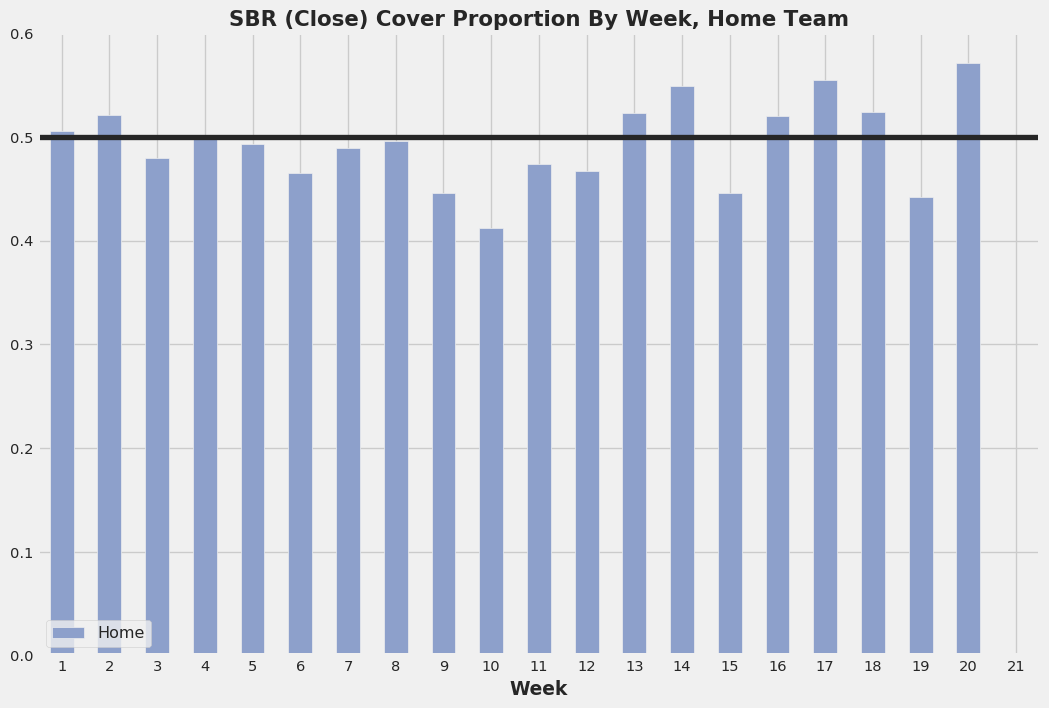

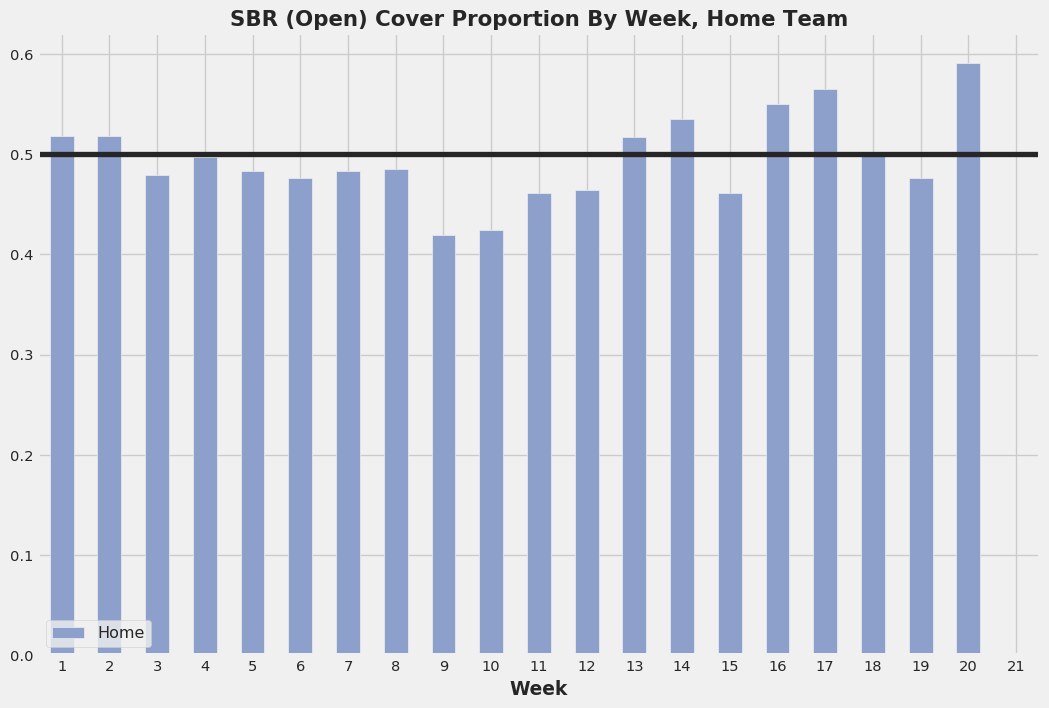

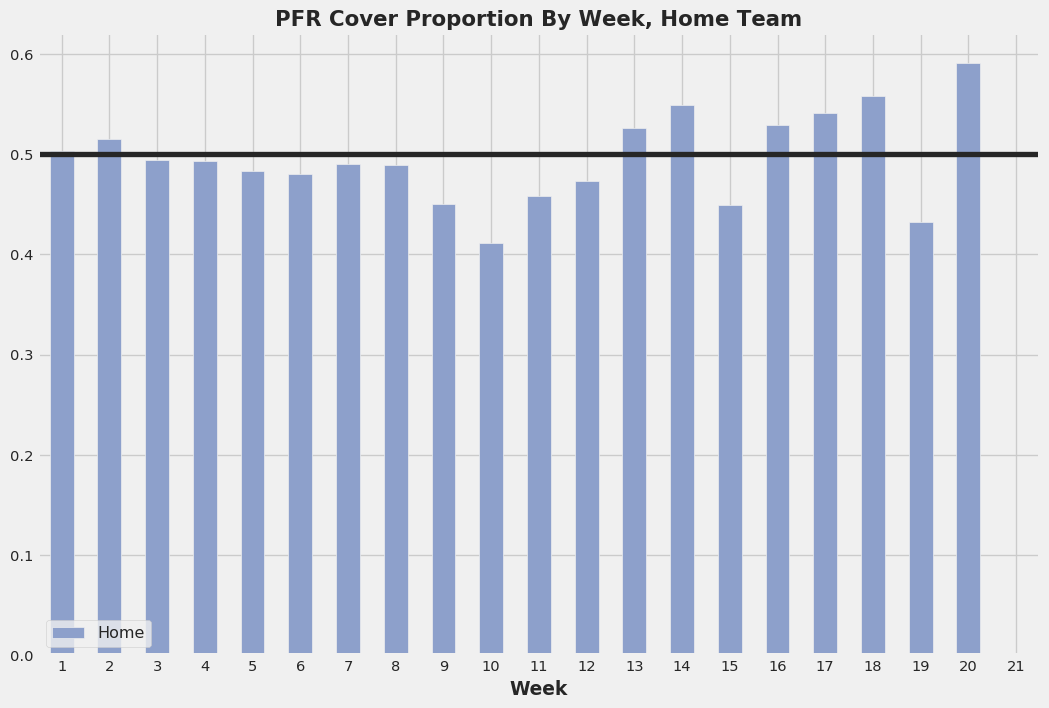

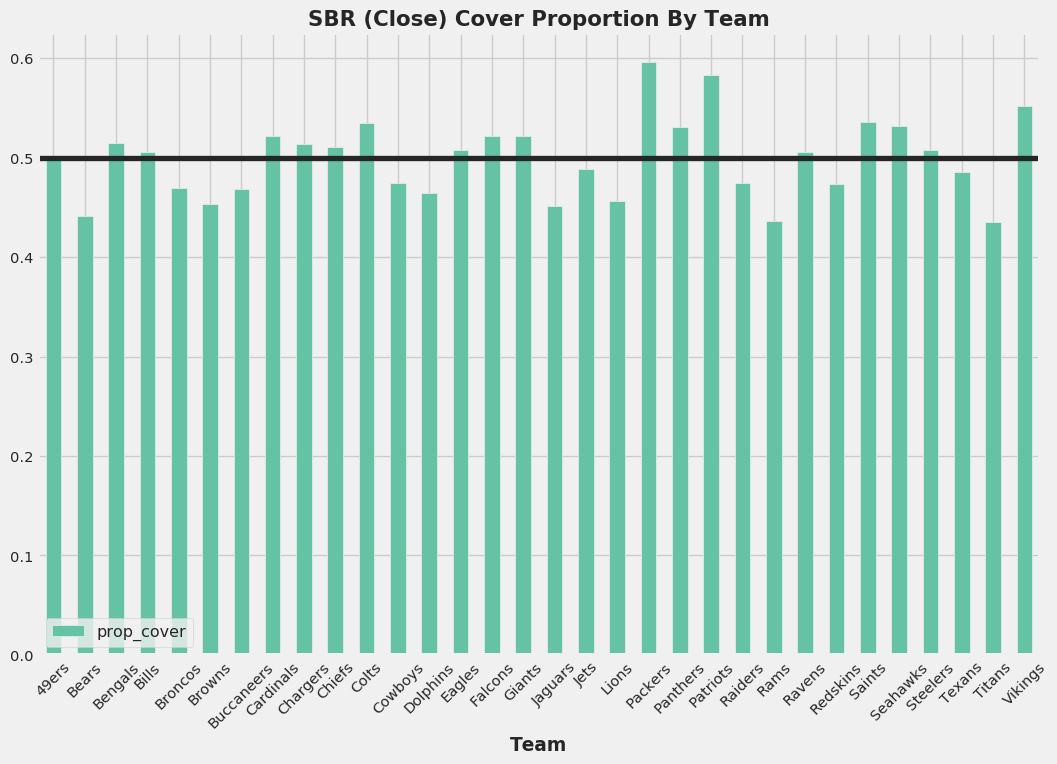

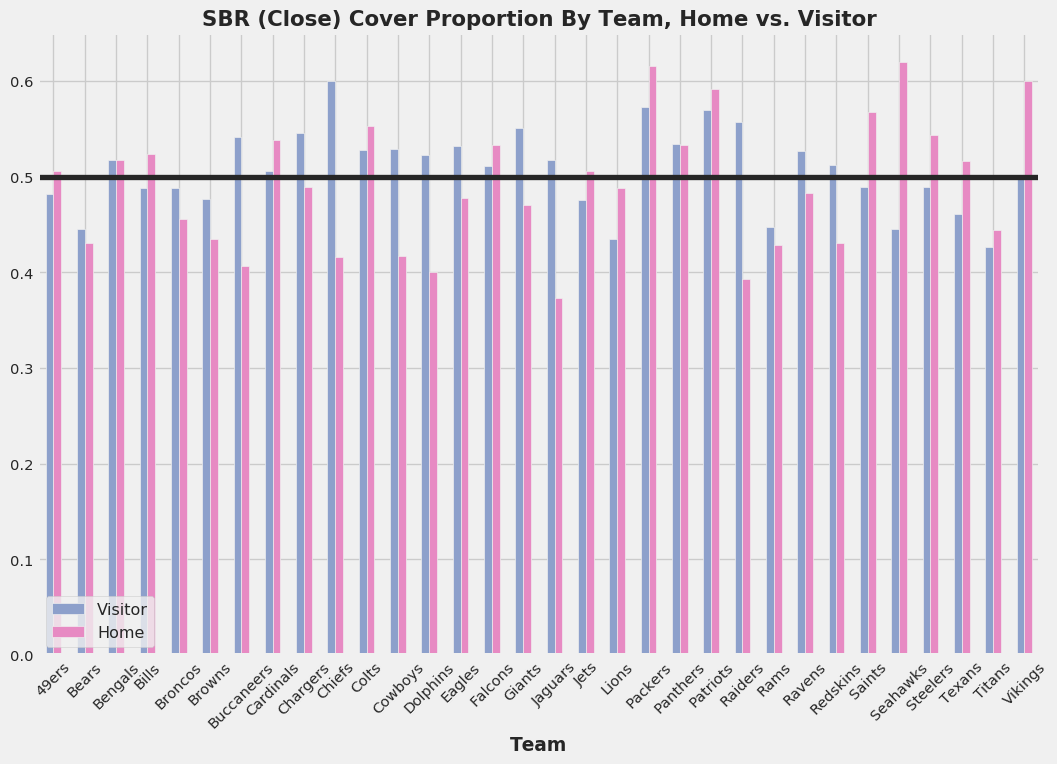

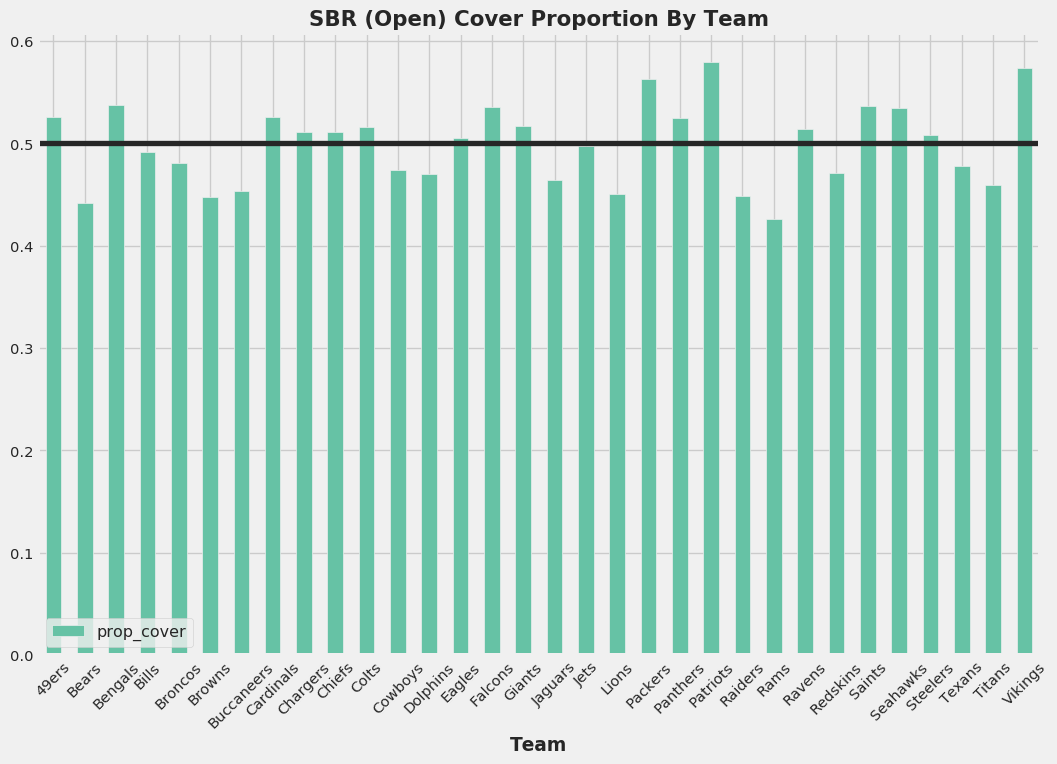

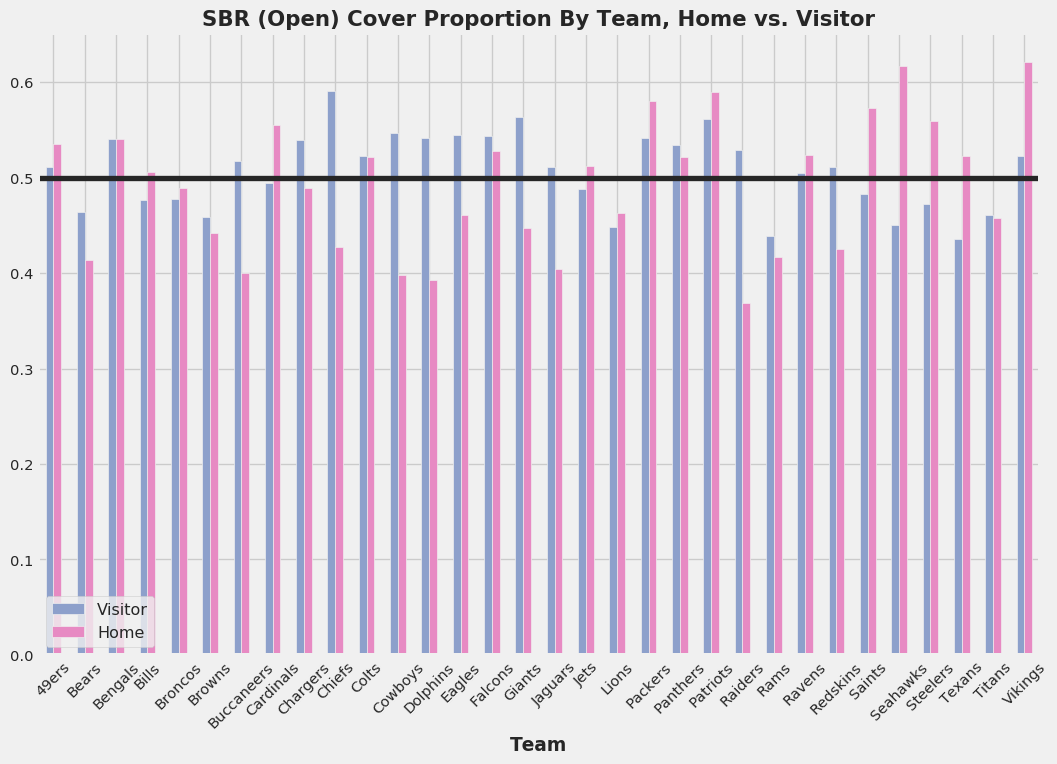

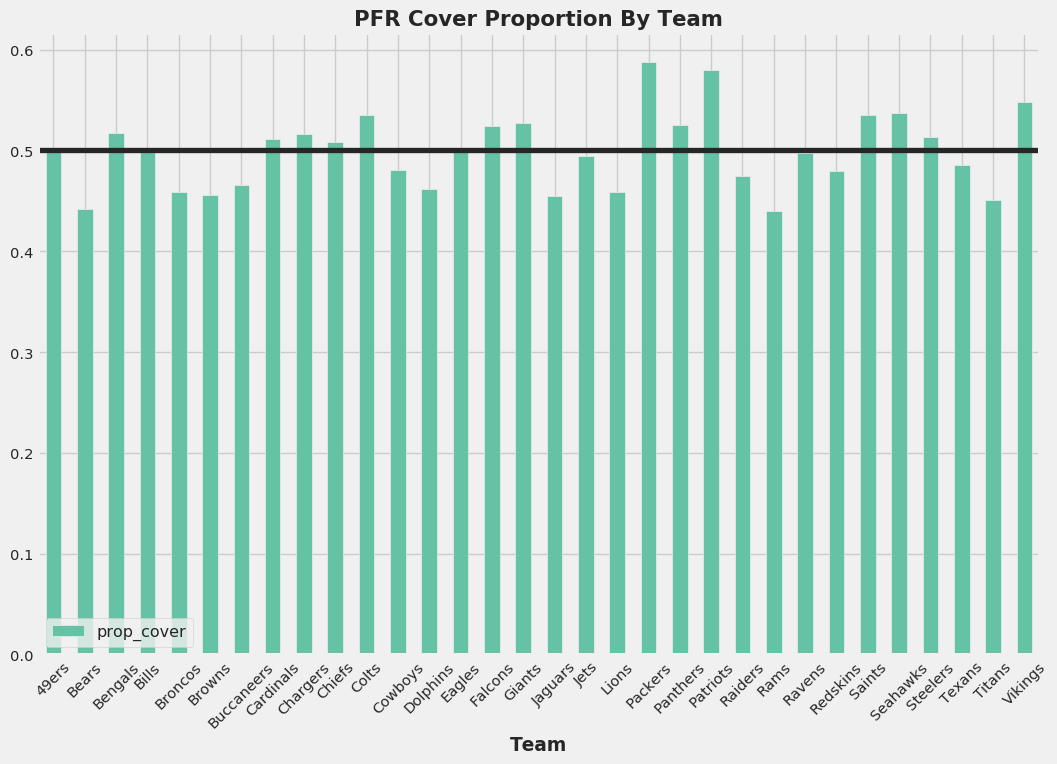

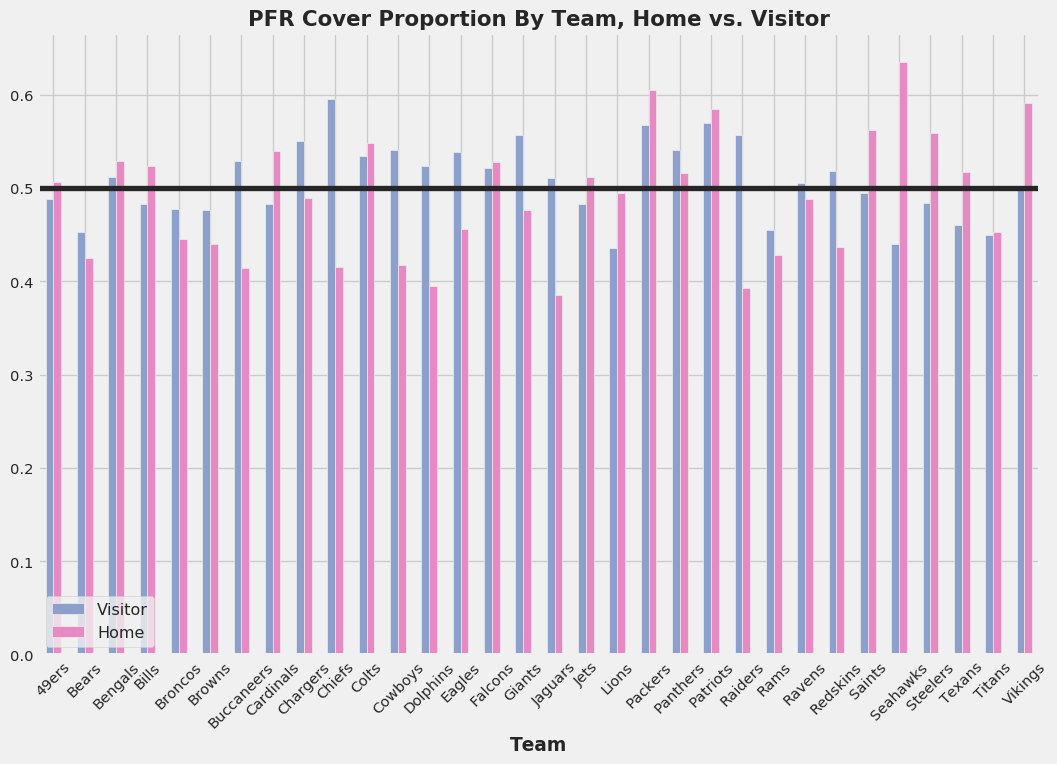

In [58]:
pivot_col = 'is_home'

data_agg = {}
for multi_dim, rot, piv_vals in [
    ('season', 0, [1]),
    ('week_id', 0, [1]),
    ('name', 45, [0,1])
]:
    data_agg[multi_dim] = {}
    for line_site in ['sbr','sbr_open','pfr']:
        ## string formatting for plots
        line_site_str = {
            'sbr': 'SBR (Close)',
            'sbr_open': 'SBR (Open)',
            'pfr': 'PFR',
        }[line_site]
        
        col_renames = { 
            'season':'Season', 
            'week_id':'Week',
            'name':'Team',
            'opp_name':'Opposing Team',
            '0':'Visitor', 
            '1':'Home' 
        }

        data_agg[multi_dim][line_site] = {}
        for do_pivot in [0, 1]:
            if do_pivot == 1:
                ## aggregation/plot
                data = df.groupby(pivot_col, multi_dim)\
                         .pivot('did_cover_{}'.format(line_site))\
                         .count()\
                         .withColumn('prop_cover', col('1') / (col('-1') + col('1')))\
                         .groupby(multi_dim)\
                         .pivot(pivot_col, values=piv_vals)\
                         .agg(F.sum('prop_cover').alias('prop_cover'))\
                         .toPandas()\
                         .sort_values(by=multi_dim)\
                         .rename(columns=col_renames)\
                         .set_index(col_renames[multi_dim])
                
                title = '{} Cover Proportion By {}, '.format(
                                    line_site_str, col_renames[multi_dim]
                                )

                if len(piv_vals) == 2:
                    title += 'Home vs. Visitor'
                elif piv_vals == [0]:
                    title += 'Visiting Team'
                else:
                    title += 'Home Team'
                    
                _ = data.plot(
                        kind='bar', rot=rot, color=colors[2:4], title=title
                    )
                _ = plt.axhline(y=0.5)
                _ = plt.legend(loc=3)

                data_agg[multi_dim][line_site]['pivot'] = data
                
            elif len(piv_vals) > 1:
                ## aggregation/plot
                data = df.groupby(multi_dim)\
                         .pivot('did_cover_{}'.format(line_site))\
                         .count()\
                         .withColumn('prop_cover', col('1') / (col('-1') + col('1')))\
                         .select(multi_dim, 'prop_cover')\
                         .toPandas()\
                         .sort_values(by=multi_dim)\
                         .rename(columns=col_renames)\
                         .set_index(col_renames[multi_dim])

                _ = data.plot(
                    kind='bar', rot=rot, legend=None,
                    title='{} Cover Proportion By {}'
                             .format(line_site_str, col_renames[multi_dim])
                    )
                _ = plt.axhline(y=0.5)
                _ = plt.legend(loc=3)

                data_agg[multi_dim][line_site]['no_pivot'] = data                

,Visitor,Home
Team,,
49ers,0.482353,0.505882
Bears,0.445783,0.430233
Bengals,0.517241,0.517241
Bills,0.488095,0.523810
Broncos,0.488372,0.455556
Browns,0.476744,0.435294
Buccaneers,0.541176,0.406977
Cardinals,0.505618,0.538462
Chargers,0.545455,0.488889


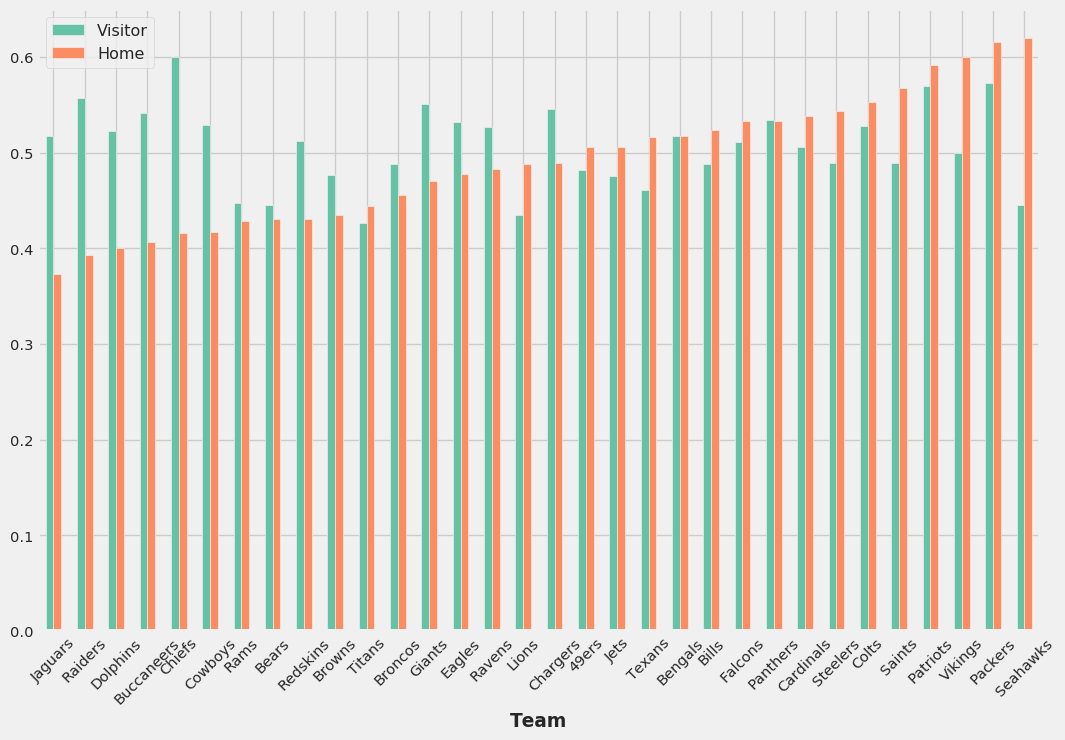

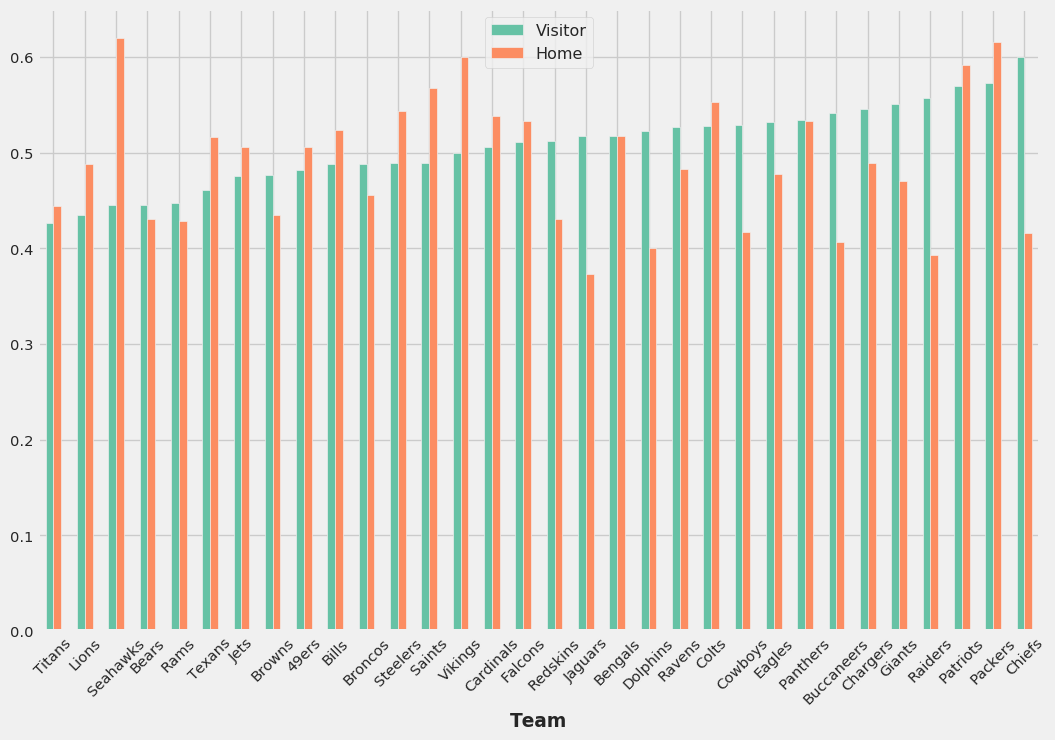

In [59]:
data_agg['name']['sbr']['pivot']
data_agg['name']['sbr']['pivot'].sort_values(by='Home').plot(kind='bar', rot=45)
data_agg['name']['sbr']['pivot'].sort_values(by='Visitor').plot(kind='bar', rot=45)

#### Notable to see Patriots and Packers, 2 of the most popular and best teams over the past 11 years -- will dig into that during feature engineering

,prop_cover
Team,
Titans,0.435294
Rams,0.436047
Bears,0.441176
Jaguars,0.451429
Browns,0.453488
Lions,0.456140
Dolphins,0.464706
Buccaneers,0.468208
Broncos,0.469274


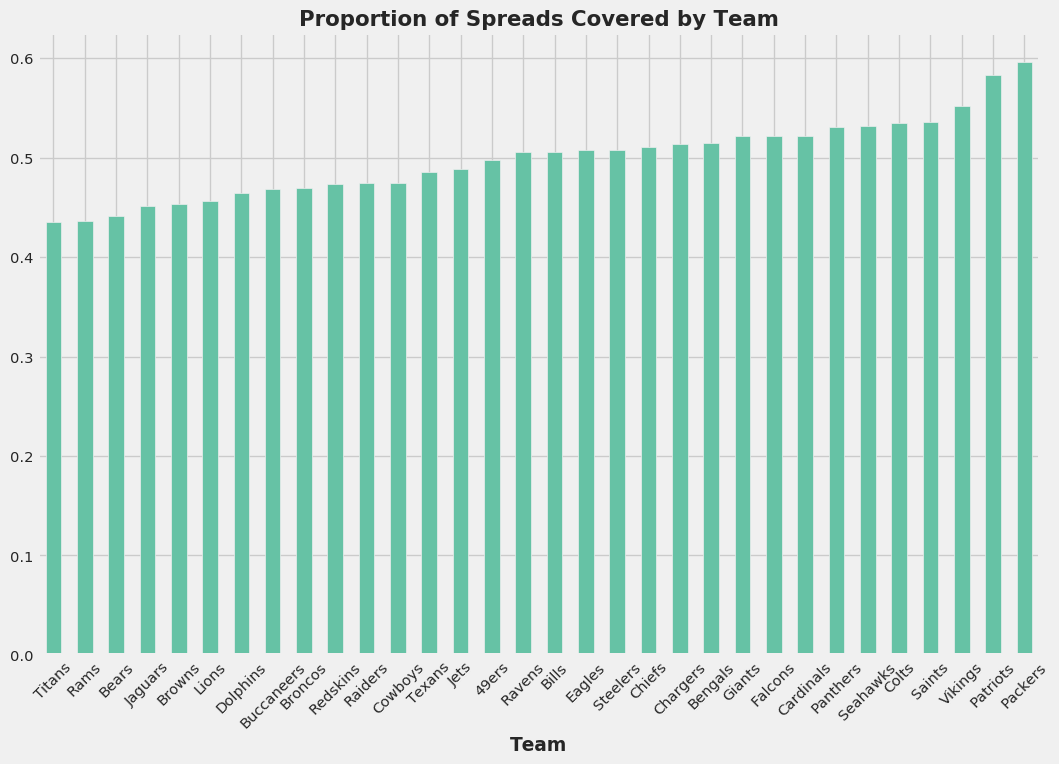

In [60]:
data_agg['name']['sbr']['no_pivot'].sort_values(by='prop_cover')
data_agg['name']['sbr']['no_pivot'].sort_values(by='prop_cover').plot(
    kind='bar', rot=45, legend=None, 
    title='Proportion of Spreads Covered by Team'
)